`TTbarResCoffea` Notebook to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
This module must be run twice: 
   1. Make the mistag rate in the "anti-tag and probe" selection 
and the expectation in the signal region from MC,
   1. Applies that mistag rate and the mod-mass procedure to the single-tag selection. 

These are all done in bins of
b-tag categories (0, 1, $\ge 2$) and rapidity ($|y| \le 1.0$, $|y| > 1.0$).
The signal region is two top-tagged jets. 
The background estimate is the single-tag selection weighted by the mistag rate from the
"anti-tag and probe" region, with the mass of the weighted jet set to a random
value from QCD MC in the 1-ttag region. 


The preselection is:
- AK4-based $H_{T} > 1100$ GeV (to be on the trigger plateau). 
- $\ge 2$ AK8 jets with AK8 $p_{T} > 400$ GeV and $|y| < 2.5$, loose jet ID applied from matched AK4 jets

The 1-tag selection adds:
- $\ge 1$ AK8 jet with top tagging applied to randomly-assigned tag jet. 


The anti-tag selection is disjoint from the 1-tag selection:
- $\ge 1$ AK8 jet with top tagging VETO applied to randomly-assigned tag jet. 


The 2-tag selection is:
- $\ge 2$ AK8 jets with top tagging applied to both leading jets. 


The ttbar candidate mass assumes the two leading top-tagged jets are the top quarks. 


In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools

In [2]:
xrootdstr1 = 'root://cmseos.fnal.gov//'
xrootdstr2 = 'root://cmsxrootd.fnal.gov//'
xrootdstr3 = 'root://cmsxrootd-site.fnal.gov/'

In [3]:
qcdfilename = 'QCD.txt'
with open(qcdfilename) as f:
    qcdfiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [4]:
ttbarfilename = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8.txt'
with open(ttbarfilename) as f:
    ttbarfiles = [xrootdstr1 + s.strip() for s in f.readlines()]

In [5]:
jetdatafilename = 'JetHT_Data.txt'
with open(jetdatafilename) as f:
    jetdatafiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [6]:
from distributed import Client
client = Client('coffea-dask.fnal.gov:8786')

In [12]:
"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class TTbarResProcessor(processor.ProcessorABC):
    def __init__(self, htCut=1100., minMSD=105., maxMSD=210., tau32Cut=0.7, ak8PtMin=400., bdisc=0.7,
                writePredDist=True,isData=True,year=2019):
        
        self.htCut = htCut
        self.minMSD = minMSD
        self.maxMSD = maxMSD
        self.tau32Cut = tau32Cut
        self.ak8PtMin = ak8PtMin
        self.bdisc = bdisc
        self.writePredDist = writePredDist
        self.writeHistFile = True
        self.isData = isData
        self.year=year
        
        self.ttagcats = ["at", "0t", "1t", "2t"] #anti-tag, 0, 1, >=2 ttags
        self.btagcats = ["0b", "1b", "2b"]   # 0, 1, >=2 btags
        self.ycats = ['cen', 'fwd']          # Central and forward
        # Combine categories like "0bcen", "0bfwd", etc:
        self.anacats = [ t+b+y for t,b,y in itertools.product( self.ttagcats, self.btagcats, self.ycats) ]
        print(self.anacats)
        
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        cats_axis = hist.Cat("anacat", "Analysis Category")
        
        ht_axis = hist.Bin("h_ak4ht", r"AK4 Jet H_{T} [GeV]", 50, 0, 5000)
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 50, 0, 2000)
        jetn3b1_axis = hist.Bin("n3b1", r"Jet N3", 50, 0, 1)
        ttbarmass_axis = hist.Bin("ttbarmass", r"$m_{t\bar{t}}$ [GeV]", 50, 0, 5000)
        jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", 50, -4, 4)
        jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -3.14, 3.14)
        jetp_axis = hist.Bin("jetp", r"Jet $p$ [GeV]", 50, 0, 5000)
        
        subjetmass_axis = hist.Bin("subjetmass", r"SubJet $m$ [GeV]", 50, 0, 500)
        subjetpt_axis = hist.Bin("subjetpt", r"SubJet $p_{T}$ [GeV]", 50, 0, 2000)
        subjeteta_axis = hist.Bin("subjeteta", r"SubJet $\eta$", 50, -4, 4)
        subjetphi_axis = hist.Bin("subjetphi", r"SubJet $\phi$", 50, -3.14, 3.14)

        self._accumulator = processor.dict_accumulator({
            'h_ak4ht'  : hist.Hist("Counts", dataset_axis, cats_axis, ht_axis),
            'ttbarmass': hist.Hist("Counts", dataset_axis, cats_axis, ttbarmass_axis),
            'jetmass':   hist.Hist("Counts", dataset_axis, cats_axis, jetmass_axis),
            'jetpt':     hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'jeteta':    hist.Hist("Counts", dataset_axis, cats_axis, jeteta_axis),
            'jetphi':    hist.Hist("Counts", dataset_axis, cats_axis, jetphi_axis),
            'numerator': hist.Hist("Counts", dataset_axis, cats_axis, jetp_axis),
            'denominator': hist.Hist("Counts", dataset_axis, cats_axis, jetp_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        
        output = self.accumulator.identity()
        
        
        #dataset = events.metadata['dataset']
        dataset = df['dataset']
        FatJets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            msoftdrop=df['FatJet_msoftdrop'],
            jetId=df['FatJet_jetId'],
            tau1=df['FatJet_tau1'],
            tau2=df['FatJet_tau2'],
            tau3=df['FatJet_tau3'],
            tau4=df['FatJet_tau4'],
            n3b1=df['FatJet_n3b1'],
            btagDeepB=df['FatJet_btagDeepB'],
            deepTag_TvsQCD=df['FatJet_deepTag_TvsQCD'],
            deepTagMD_TvsQCD=df['FatJet_deepTagMD_TvsQCD']
            )
        SubJets = JaggedCandidateArray.candidatesfromcounts(
            df['nSubJet'],
            pt=df['SubJet_pt'],
            eta=df['SubJet_eta'],
            phi=df['SubJet_phi'],
            mass=df['SubJet_mass'],
            
            tau1=df['SubJet_tau1'],
            tau2=df['SubJet_tau2'],
            tau3=df['SubJet_tau3'],
            tau4=df['SubJet_tau4'],
            n2b1=df['SubJet_n2b1'],
            n3b1=df['SubJet_n3b1'],
            btagDeepB=df['SubJet_btagDeepB']
            )
        
        evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        output['cutflow']['all events'] += FatJets.size

        oneFatJet = (FatJets.counts >= 1)
        FatJets = FatJets[oneFatJet]
        evtweights = evtweights[oneFatJet]
        output['cutflow']['one FatJets'] += oneFatJet.sum()
        
        twoFatJets = (FatJets.counts >= 2)
        FatJets = FatJets[twoFatJets]
        evtweights = evtweights[twoFatJets]
        output['cutflow']['two FatJets'] += twoFatJets.sum()

        jet_id = (FatJets.jetId > 0)
        
        FatJets = FatJets[jet_id]
        output['cutflow']['jet id'] += jet_id.any().sum()
        
        jetkincut_index = (FatJets.pt > self.ak8PtMin) & (np.abs(FatJets.eta) < 2.5)
        FatJets = FatJets[ jetkincut_index ]
        output['cutflow']['jet kin'] += jetkincut_index.any().sum()

        twoFatJetsKin = (FatJets.counts >= 2)
        FatJets = FatJets[twoFatJetsKin]
        evtweights = evtweights[twoFatJetsKin]
        output['cutflow']['two FatJets and jet kin'] += twoFatJetsKin.sum()    
        
        index = JaggedArray.fromcounts(np.ones(len(FatJets), dtype='i'), np.random.randint(2, size=len(FatJets)))
        jet0 = FatJets[index]
        jet1 = FatJets[1 - index]
        
        ttbarcands = jet0.cross(jet1) #FatJets[:,0:2].distincts()
        
        oneTTbar = (ttbarcands.counts >= 1)
        output['cutflow']['>= one oneTTbar'] += oneTTbar.sum()
        ttbarcands = ttbarcands[oneTTbar]
        evtweights = evtweights[oneTTbar]
        FatJets = FatJets[oneTTbar]

        
        dPhiCut = (ttbarcands.i0.p4.delta_phi(ttbarcands.i1.p4) > 2.1).flatten()
        output['cutflow']['dPhi > 2.1'] += dPhiCut.sum()
        ttbarcands = ttbarcands[dPhiCut]
        evtweights = evtweights[dPhiCut]
        FatJets = FatJets[dPhiCut]        
        # Now get the analysis categories. 
        # They are (central, forward)   cross   (0b,1b,>=2b)
        cen = np.abs(ttbarcands.i0.p4.y - ttbarcands.i1.p4.y) < 1.0
        fwd = (~cen)
        tau32_i0 = np.where(ttbarcands.i0.tau2>0,ttbarcands.i0.tau3/ttbarcands.i0.tau2, 0 )
        tau32_i1 = np.where(ttbarcands.i1.tau2>0,ttbarcands.i1.tau3/ttbarcands.i1.tau2, 0 )
        taucut_i0 = tau32_i0 < self.tau32Cut
        taucut_i1 = tau32_i1 < self.tau32Cut
        mcut_i0 = (self.minMSD < ttbarcands.i0.msoftdrop) & (ttbarcands.i0.msoftdrop < self.maxMSD) 
        mcut_i1 = (self.minMSD < ttbarcands.i1.msoftdrop) & (ttbarcands.i1.msoftdrop < self.maxMSD) 

        ttag_i0 = (taucut_i0) & (mcut_i0)
        ttag_i1 = (taucut_i1) & (mcut_i1)
        antitag = (~taucut_i0) & (mcut_i0) #Probe will always be ttbarcands.i1
        ttag0 = (~ttag_i0) & (~ttag_i1)
        ttag1 = ttag_i0 ^ ttag_i1
        ttag2 = ttag_i0 & ttag_i1

        btag_i0 = (ttbarcands.i0.btagDeepB > self.bdisc)
        btag_i1 = (ttbarcands.i1.btagDeepB > self.bdisc)
        
        btag0 = (~btag_i0) & (~btag_i1)
        btag1 = btag_i0 ^ btag_i1
        btag2 = btag_i0 & btag_i1
        
        antitag_probe = np.logical_and(antitag, ttag_i1) #Found an antitag and ttaged probe pair
        #print('for num =   ',antitag_probe[antitag_probe.flatten()].shape)
        #print('for denom = ',antitag[antitag.flatten()].shape)
        #print()
        #print('at = ', antitag)
        #print('atp = ', antitag_probe)
        regs = [cen,fwd]
        btags = [btag0,btag1,btag2]
        ttags = [antitag,ttag0,ttag1,ttag2]
        cats = [ (t&b&y).flatten() for t,b,y in itertools.product( ttags, btags, regs) ]
        
        labels_and_categories = dict(zip( self.anacats, cats ))
        ttbarmass = ttbarcands.p4.sum().mass.flatten()
        jetpt = ttbarcands.pt.flatten()
        jeteta = ttbarcands.eta.flatten()
        jetphi = ttbarcands.phi.flatten()
        weights = evtweights.flatten()
        weights[weights < 0] = 0
        
        pT = ttbarcands.i1.pt.flatten()
        eta = ttbarcands.i1.eta.flatten()
        pz = np.sinh(eta)*pT
        p = np.absolute(np.sqrt(pT**2 + pz**2))
        numerator = np.where(antitag_probe, p, -9999)
        denominator = np.where(antitag, p, -9999)
        #print("n = ", numerator)
        #print("d = ", denominator)

        for ilabel,icat in labels_and_categories.items():
            output['cutflow'][ilabel] += np.sum(icat)
            output['ttbarmass'].fill(dataset=dataset, anacat=ilabel, 
                                ttbarmass=ttbarmass[icat],
                                weight=weights[icat])
            output['jetpt'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=jetpt[icat],
                                weight=weights[icat])
            output['jeteta'].fill(dataset=dataset, anacat=ilabel, 
                                jeteta=jeteta[icat],
                                weight=weights[icat])
            output['jetphi'].fill(dataset=dataset, anacat=ilabel, 
                                jetphi=jetphi[icat],
                                weight=weights[icat])
            output['numerator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=numerator[icat],
                                weight=weights[icat])
            output['denominator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=denominator[icat],
                                weight=weights[icat])
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [21]:
tstart = time.time()

fileset = {
    'TTbar':ttbarfiles,
    'QCD':qcdfiles, # QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8
    #'JetHT':jetdatafiles
}

output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=TTbarResProcessor(),
                                  #executor=processor.dask_executor,
                                  executor=processor.iterative_executor,
                                  executor_args={
                                      'client': client, 
                                      'nano':False, 
                                      'flatten':True, 
                                      'workers': 4},
                                  chunksize=50000 , maxchunks=30
                                 )

elapsed = time.time() - tstart
print(output)

['at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']



{'h_ak4ht': <Hist (dataset,anacat,h_ak4ht) instance at 0x7efbdf33e810>, 'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7efba2dfdd90>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7efb9955ce50>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7efb9955cf90>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7efb9a2462d0>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7efb995278d0>, 'numerator': <Hist (dataset,anacat,jetp) instance at 0x7efb99527910>, 'denominator': <Hist (dataset,anacat,jetp) instance at 0x7efb99527c50>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 2973429, 'one FatJets': 1229403, 'two FatJets': 856999, 'jet id': 856930, 'jet kin': 396414, 'two FatJets and jet kin': 295923, '>= one oneTTbar': 295923, 'dPhi > 2.1': 147570, 'at0bcen': 8, 'at0bfwd': 13061, 'at1bcen': 1, 'at1bfwd': 684, 'at2bcen': 0, 'at2bfwd': 19, '0t0bcen': 54, '0t0bfwd': 129168, '0t1bcen': 2, '0t1bfwd': 3744, '0t2bcen': 0, '0t2bfwd': 58, '1t0bce

In [ ]:
#print(output['jetpt']['TTbar'])

In [22]:
stack_fill_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,.5)}
stack_error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}


In [23]:
""" NOTHING BUT TESTS!!!"""
"""
#test = hist.plotgrid(output['ttbarmass'].integrate('anacat','0t0bfwd'), overlay='dataset', 
 #                    stack=True, fill_opts=stack_fill_opts, error_opts=stack_error_opts)
#plt.yscale('log')
#plt.autoscale(enable=True, axis='y')
#plt.title = r'0t0bfwd'

Numerator = output['numerator'].integrate('anacat', '0t0bcen').integrate('dataset', 'TTbar')
Denominator = output['denominator'].integrate('anacat', '0t0bcen').integrate('dataset', 'TTbar')
#hist.plotratio(num = Numerator, denom = Denominator)
#plt.yscale('log')
#plt.autoscale(enable=True, axis='y')

#axes_ttbarmass = hist.plotgrid(output['ttbarmass'], row="anacat", overlay="dataset",
#                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
#plt.ylim(bottom=10**(-8))
#plt.yscale('log')
#plt.autoscale(enable=True, axis='y')

axes_numerator = hist.plotgrid(output['numerator'].integrate('anacat', '0t0bcen').integrate('dataset', 'TTbar'),
                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
#plt.yscale('log')
plt.autoscale(enable=True, axis='y')

axes_denominator = hist.plotgrid(output['denominator'].integrate('anacat', '0t0bcen').integrate('dataset', 'TTbar'), 
                                 fill_opts=stack_fill_opts, error_opts=stack_error_opts)


for iax in axes_numerator.flatten():
    category = iax.get_title()
    mistag = hist.plotratio(num = Numerator, denom = Denominator,
                            error_opts={'color': 'b', 'linestyle': '-', 'ms':10})
#plt.yscale('log')
plt.autoscale(enable=True, axis='y')

"""

'\n#test = hist.plotgrid(output[\'ttbarmass\'].integrate(\'anacat\',\'0t0bfwd\'), overlay=\'dataset\', \n #                    stack=True, fill_opts=stack_fill_opts, error_opts=stack_error_opts)\n#plt.yscale(\'log\')\n#plt.autoscale(enable=True, axis=\'y\')\n#plt.title = r\'0t0bfwd\'\n\nNumerator = output[\'numerator\'].integrate(\'anacat\', \'0t0bcen\').integrate(\'dataset\', \'TTbar\')\nDenominator = output[\'denominator\'].integrate(\'anacat\', \'0t0bcen\').integrate(\'dataset\', \'TTbar\')\n#hist.plotratio(num = Numerator, denom = Denominator)\n#plt.yscale(\'log\')\n#plt.autoscale(enable=True, axis=\'y\')\n\n#axes_ttbarmass = hist.plotgrid(output[\'ttbarmass\'], row="anacat", overlay="dataset",\n#                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)\n#plt.ylim(bottom=10**(-8))\n#plt.yscale(\'log\')\n#plt.autoscale(enable=True, axis=\'y\')\n\naxes_numerator = hist.plotgrid(output[\'numerator\'].integrate(\'anacat\', \'0t0bcen\').integrate(\'dataset\'

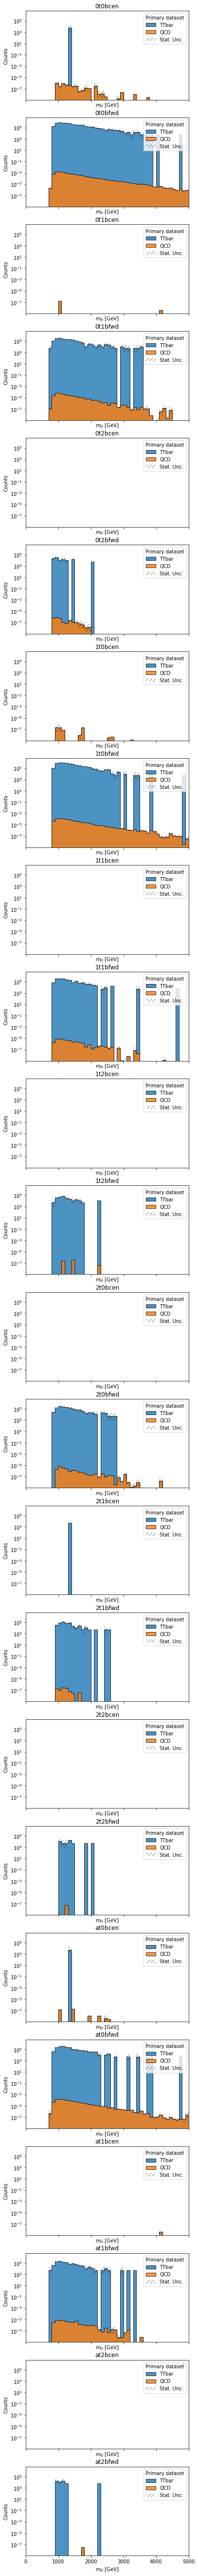

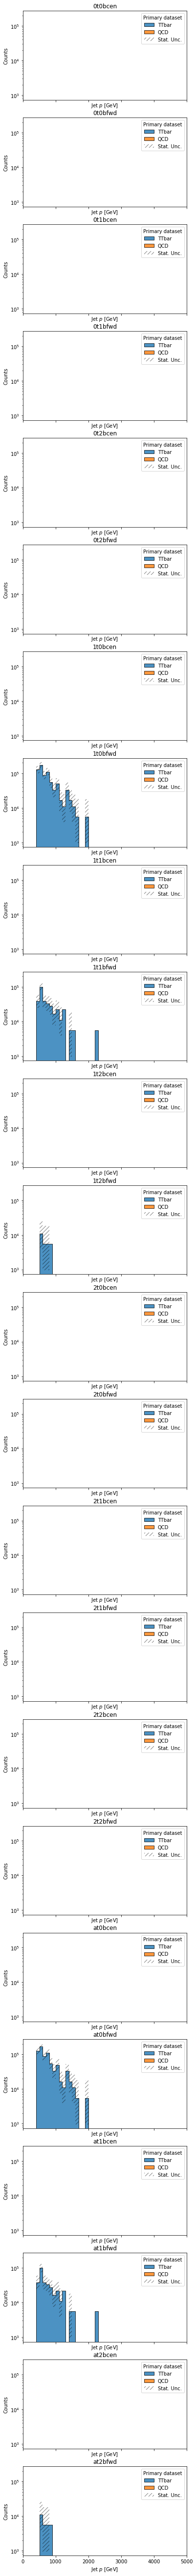

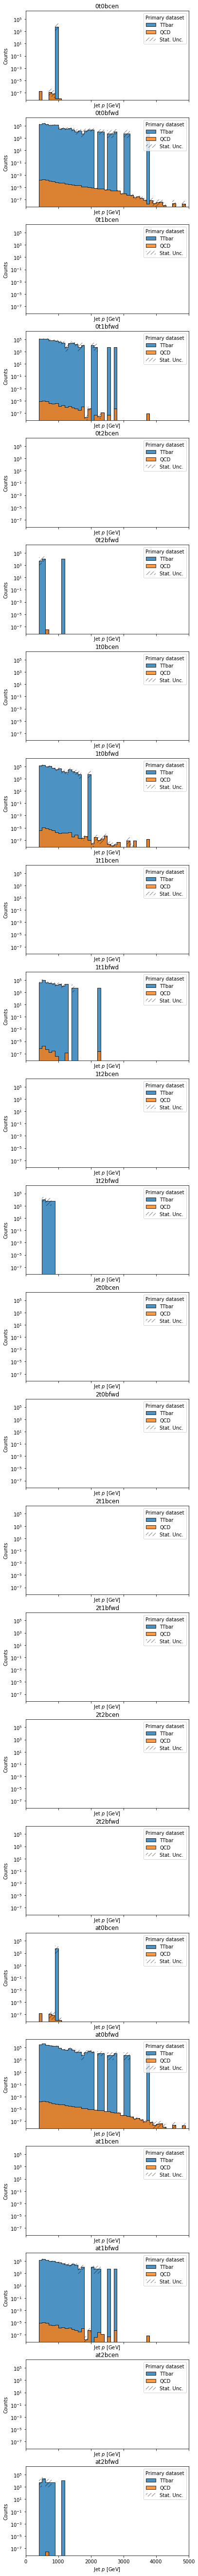

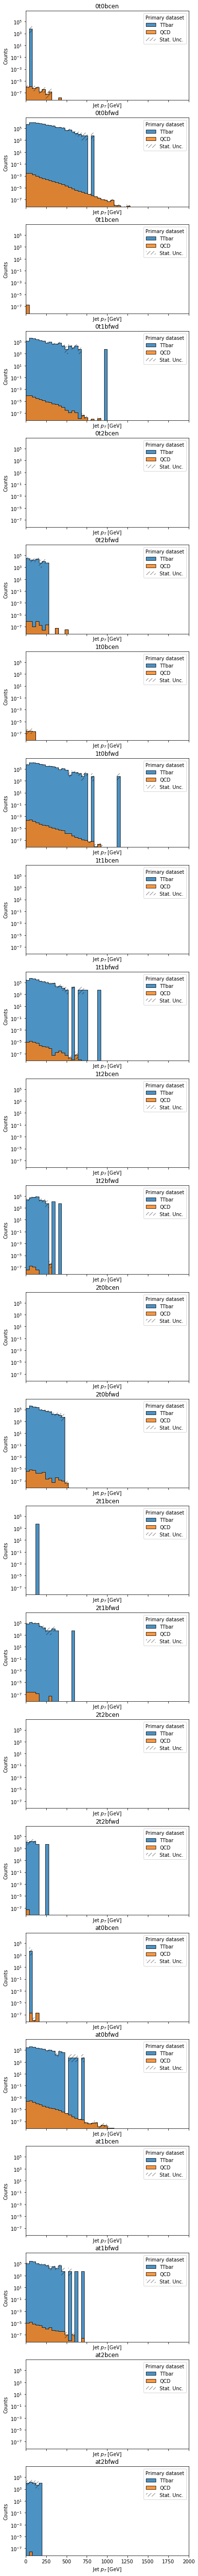

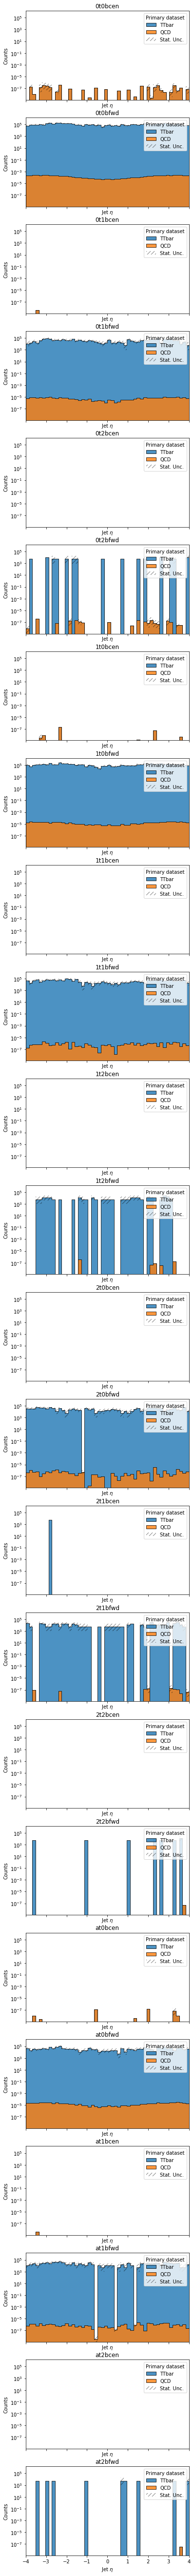

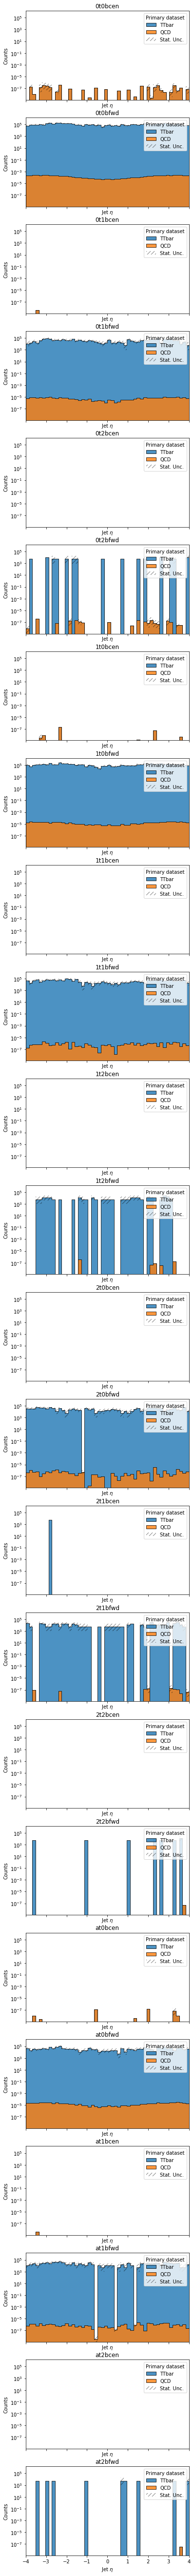

In [24]:
""" ----------- DECLARE (AND DISPLAY) ALL PLOTS ----------- """
""" Only remove stack=True option when using only one fileset """
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

axes_ttbarmass = hist.plotgrid(output['ttbarmass'], row="anacat", overlay="dataset", stack=True,
                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
plt.ylim(bottom=10**(-8))
plt.yscale('log')
plt.autoscale(enable=True, axis='y')

axes_numerator = hist.plotgrid(output['numerator'], row="anacat", overlay="dataset", stack=True,
                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
plt.ylim(bottom=10**(-8))
plt.yscale('log')
plt.autoscale(enable=True, axis='y')

axes_denominator = hist.plotgrid(output['denominator'], row="anacat", overlay="dataset", stack=True,
                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
plt.ylim(bottom=10**(-8))
plt.yscale('log')
plt.autoscale(enable=True, axis='y')

axes_jetpt = hist.plotgrid(output['jetpt'], row="anacat", overlay="dataset", stack=True,
                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
plt.ylim(bottom=10**(-8))
plt.yscale('log')
plt.autoscale(enable=True, axis='y')

axes_jeteta = hist.plotgrid(output['jeteta'], row="anacat", overlay="dataset", stack=True,
                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
plt.ylim(bottom=10**(-8))
plt.yscale('log')
plt.autoscale(enable=True, axis='y')

axes_jetphi = hist.plotgrid(output['jeteta'], row="anacat", overlay="dataset", stack=True,
                               fill_opts=stack_fill_opts, error_opts=stack_error_opts)
plt.ylim(bottom=10**(-8))
plt.yscale('log')
plt.autoscale(enable=True, axis='y')

In [25]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [26]:
def DoesDirectoryExist(mypath): #extra precaution
    '''Checks to see if Directory exists before making a new one'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [27]:
# (hist, string, string, string, string)
def SavePlot(name_of_axis, name_of_cat, name_of_plot, plot_type, name_of_directory): 
    title = name_of_cat
    filename = '/' + name_of_plot + '_' + title + '.' + plot_type
    plt.title(title) 
    plt.savefig(name_of_directory + filename, bbox_inches="tight")
    print(filename + " successfully created")

/mistag_TTbar_0t0bcen.pdf successfully created
/mistag_TTbar_0t0bfwd.pdf successfully created
/mistag_TTbar_0t1bcen.pdf successfully created
/mistag_TTbar_0t1bfwd.pdf successfully created
/mistag_TTbar_0t2bcen.pdf successfully created
/mistag_TTbar_0t2bfwd.pdf successfully created
/mistag_TTbar_1t0bcen.pdf successfully created
/mistag_TTbar_1t0bfwd.pdf successfully created
/mistag_TTbar_1t1bcen.pdf successfully created
/mistag_TTbar_1t1bfwd.pdf successfully created
/mistag_TTbar_1t2bcen.pdf successfully created
/mistag_TTbar_1t2bfwd.pdf successfully created
/mistag_TTbar_2t0bcen.pdf successfully created
/mistag_TTbar_2t0bfwd.pdf successfully created
/mistag_TTbar_2t1bcen.pdf successfully created
/mistag_TTbar_2t1bfwd.pdf successfully created
/mistag_TTbar_2t2bcen.pdf successfully created
/mistag_TTbar_2t2bfwd.pdf successfully created
/mistag_TTbar_at0bcen.pdf successfully created
/mistag_TTbar_at0bfwd.pdf successfully created
/mistag_TTbar_at1bcen.pdf successfully created
/mistag_TTbar

/jetphi_at1bfwd.pdf successfully created
/jetphi_at2bcen.pdf successfully created
/jetphi_at2bfwd.pdf successfully created


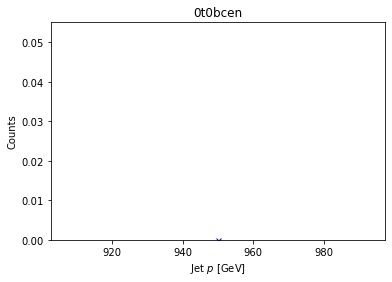

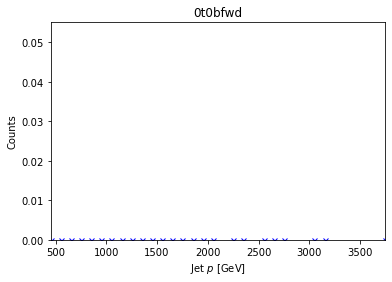

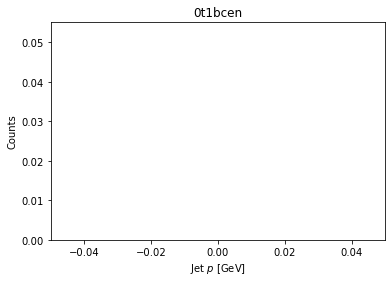

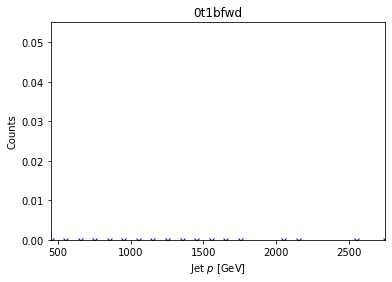

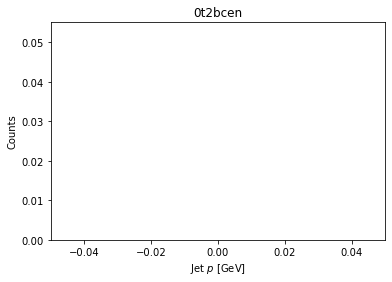

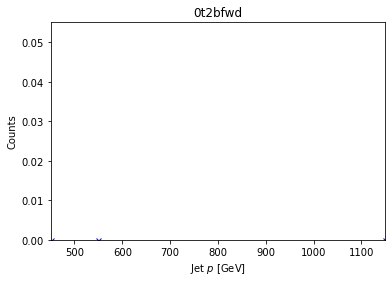

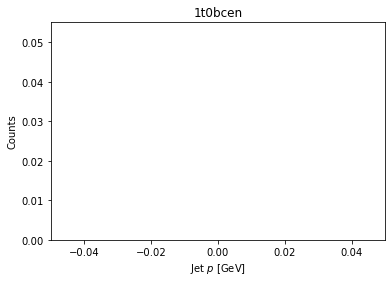

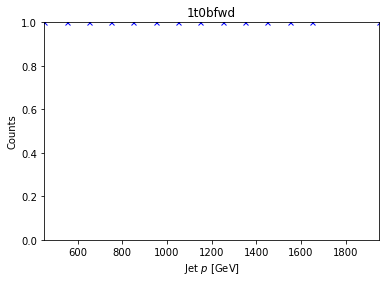

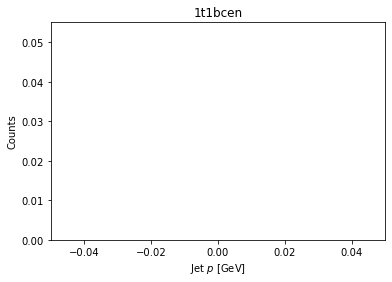

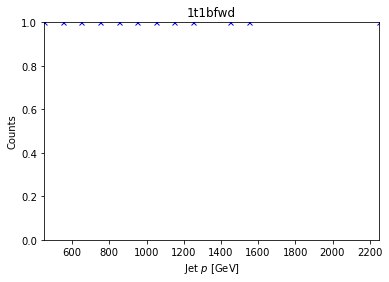

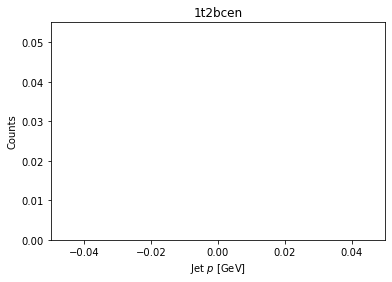

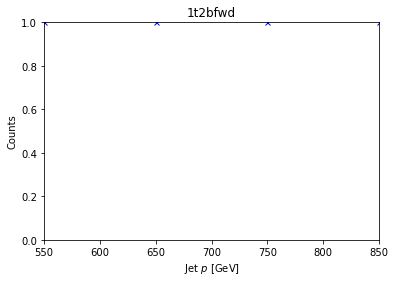

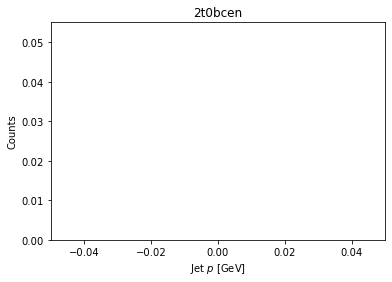

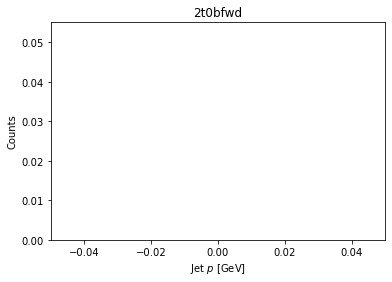

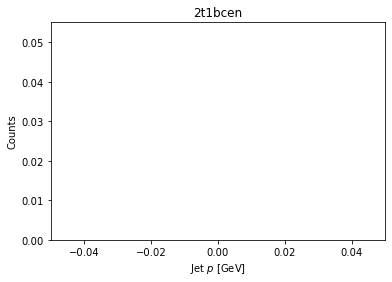

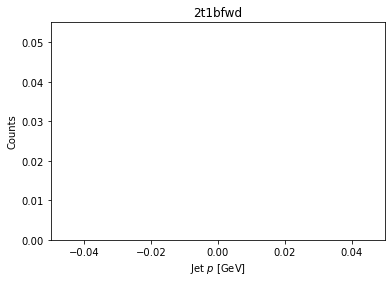

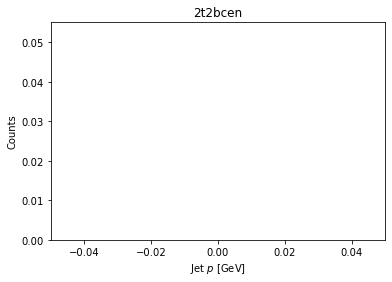

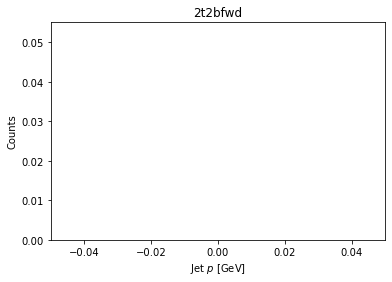

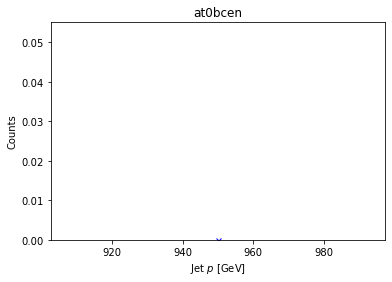

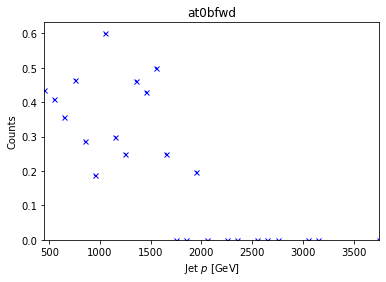

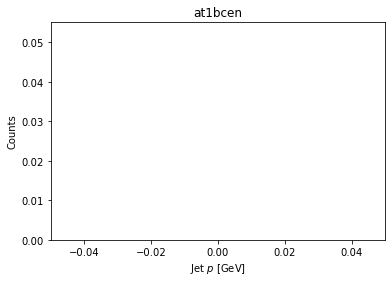

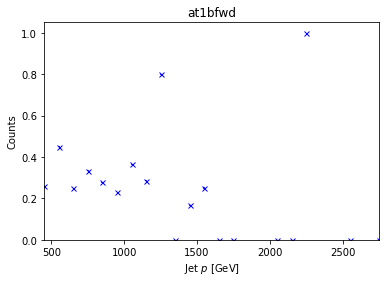

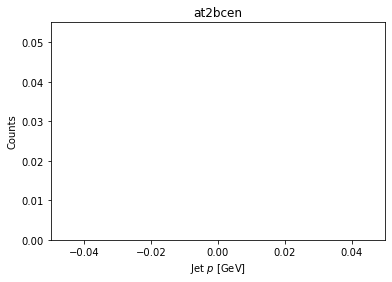

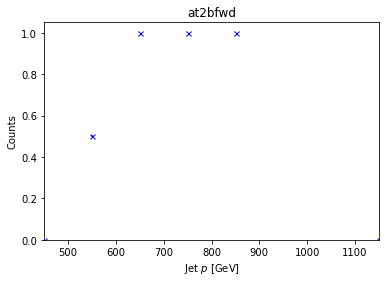

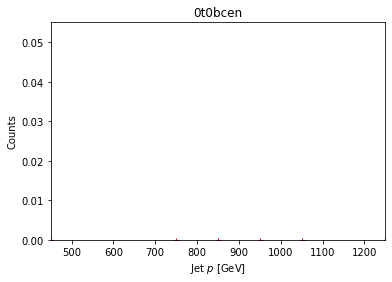

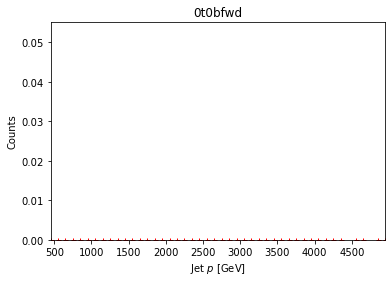

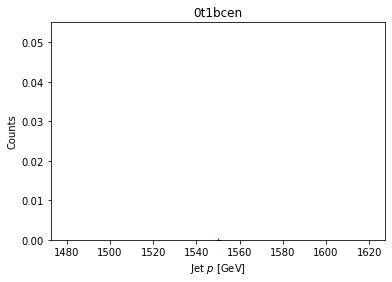

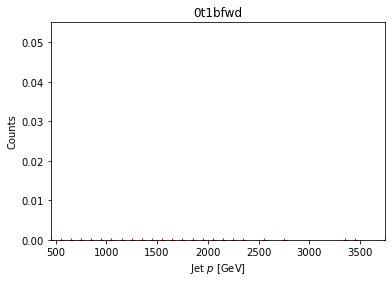

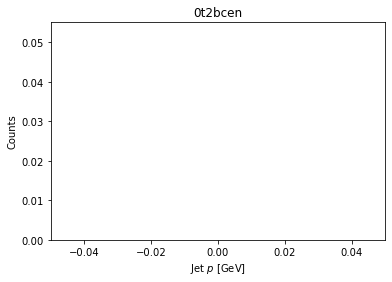

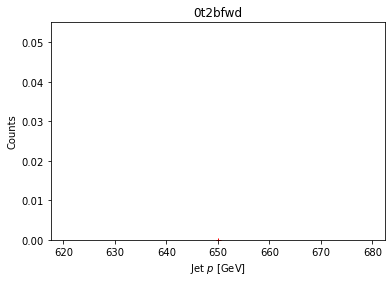

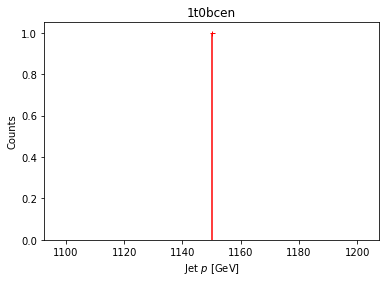

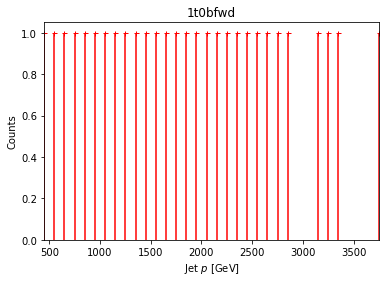

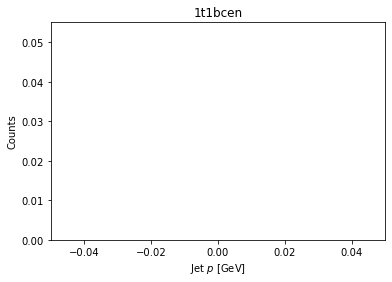

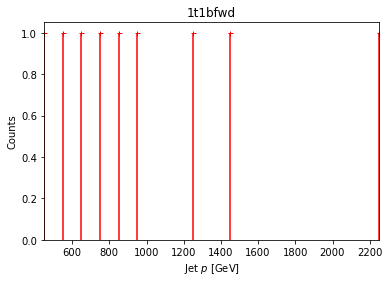

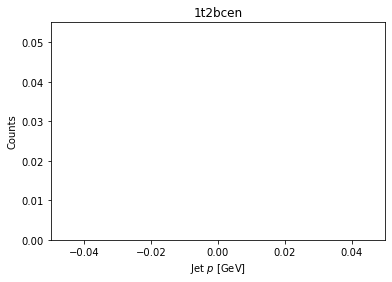

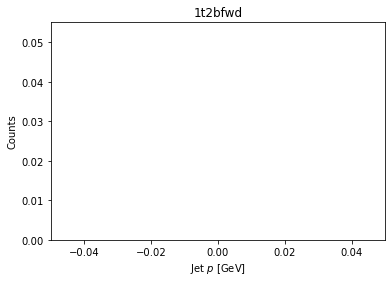

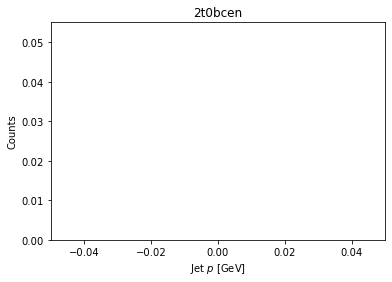

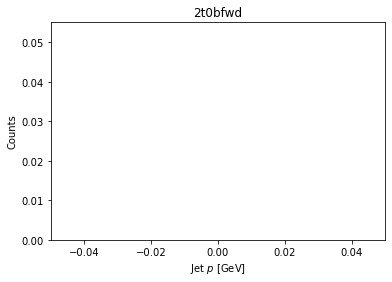

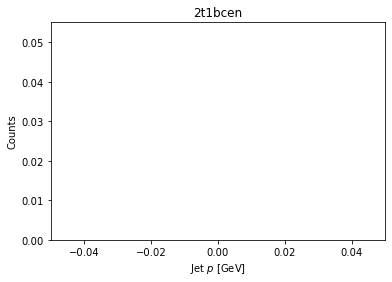

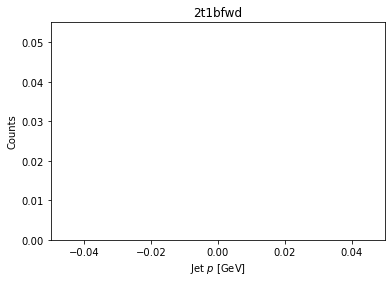

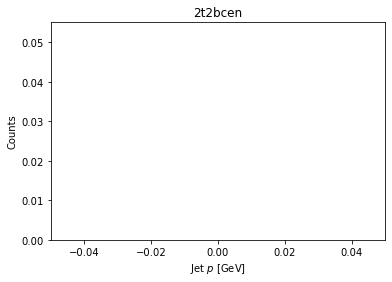

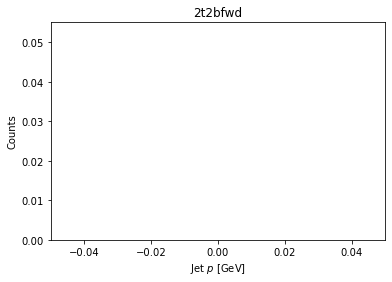

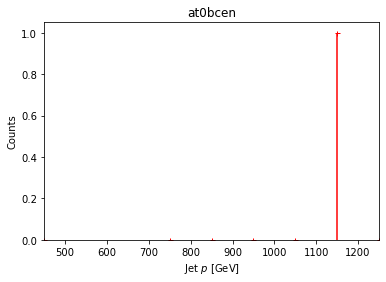

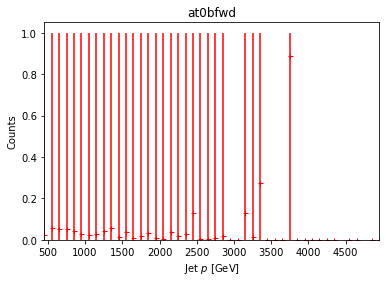

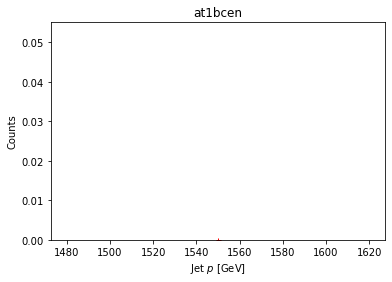

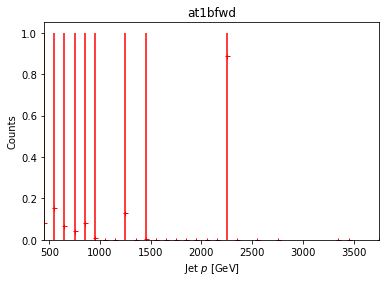

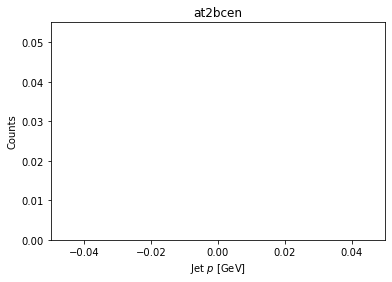

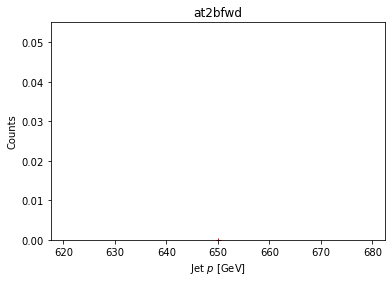

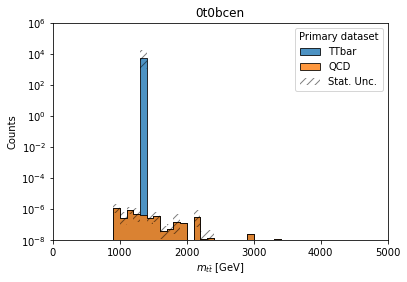

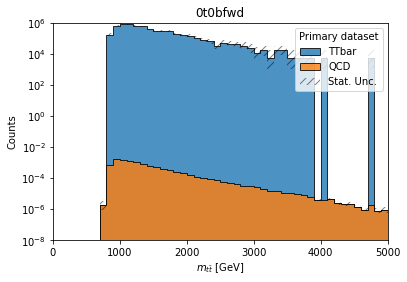

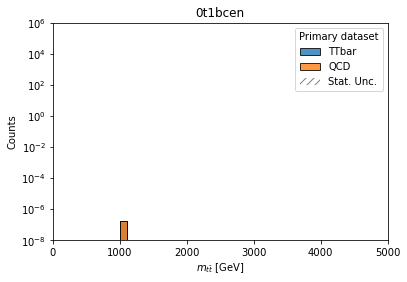

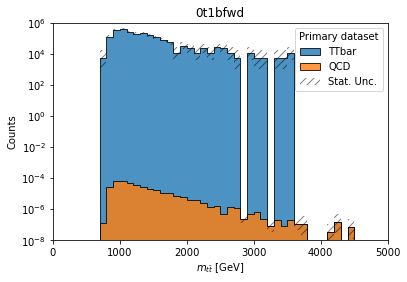

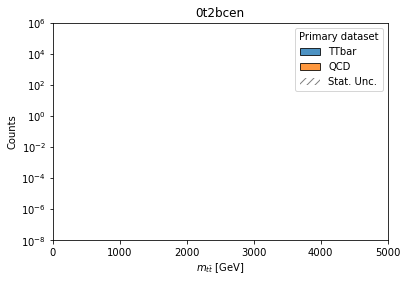

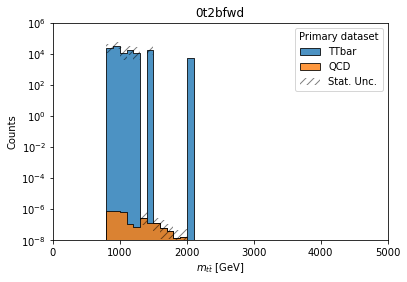

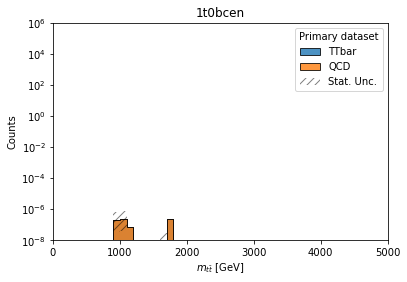

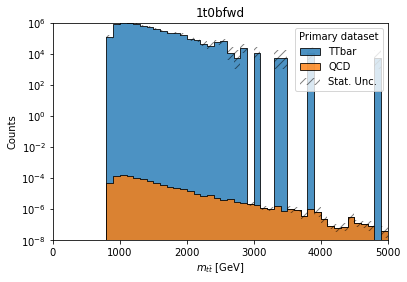

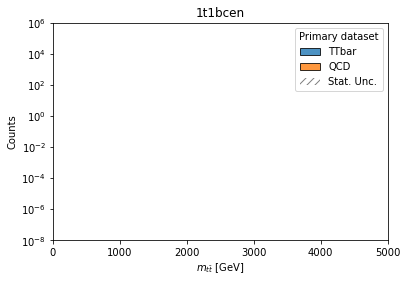

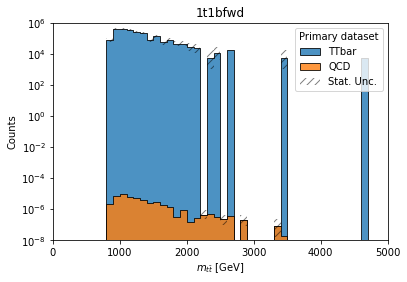

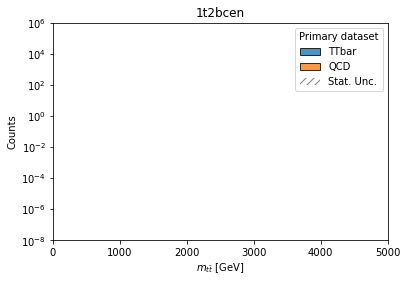

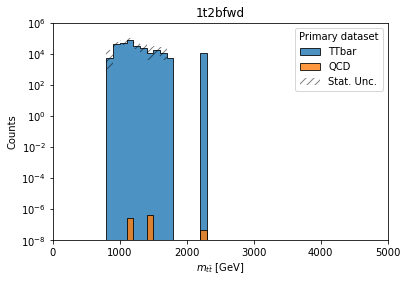

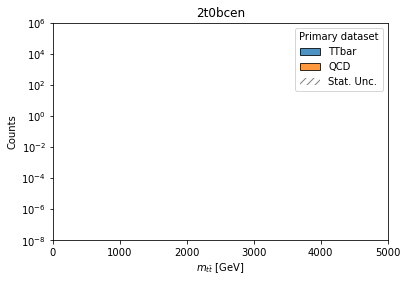

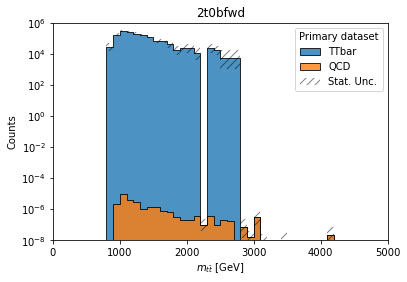

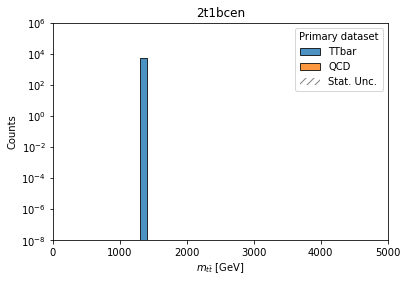

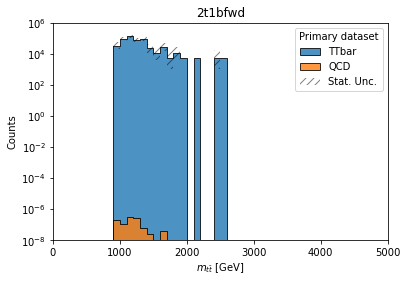

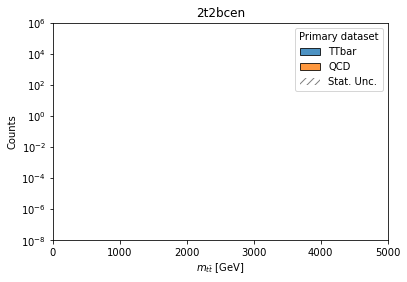

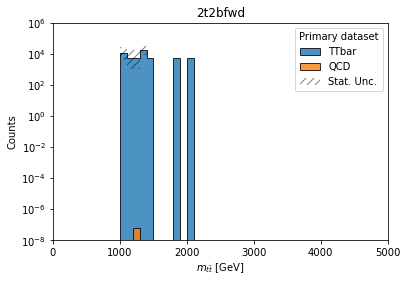

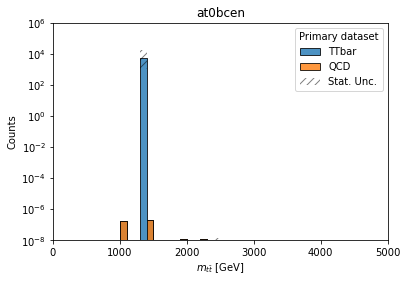

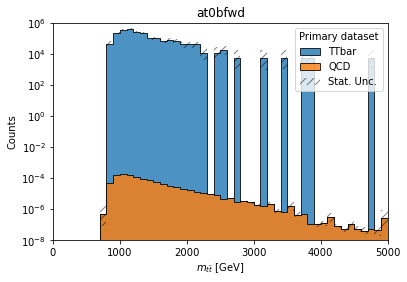

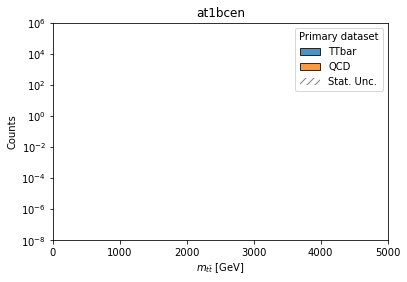

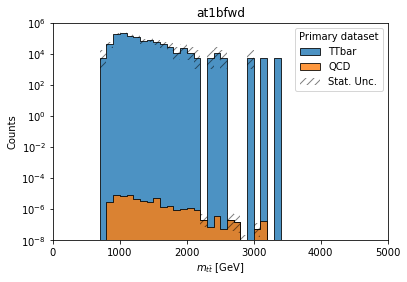

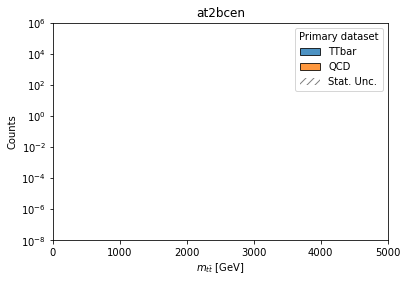

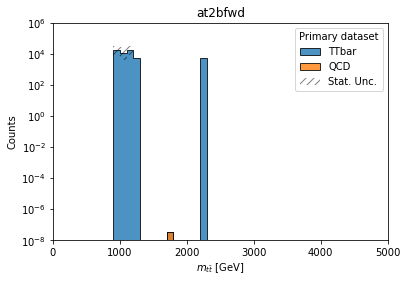

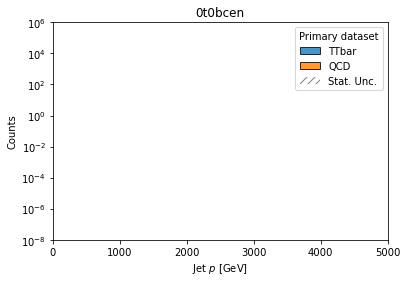

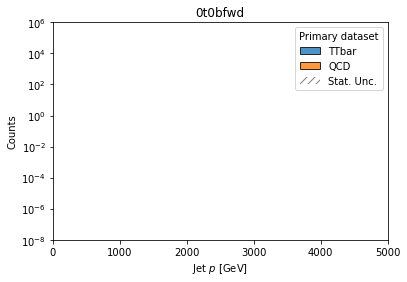

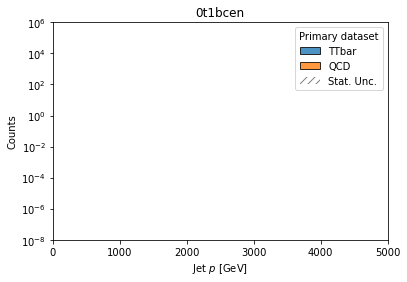

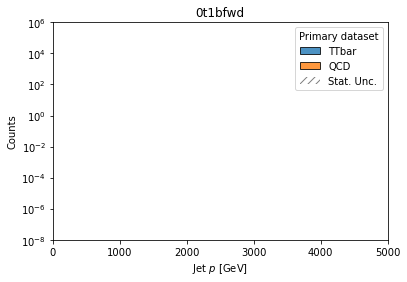

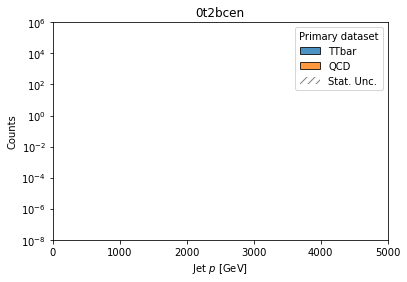

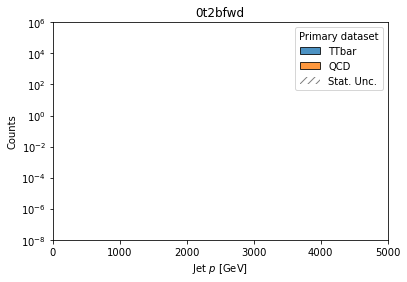

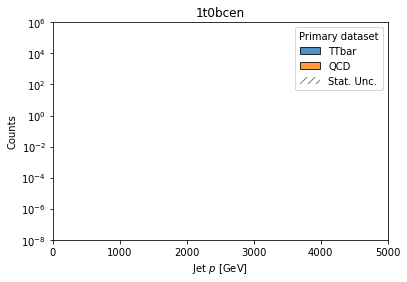

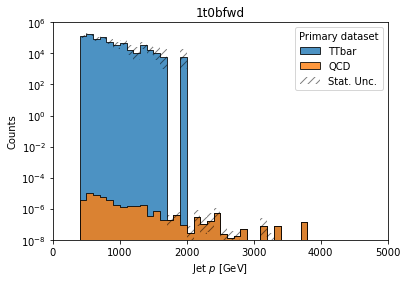

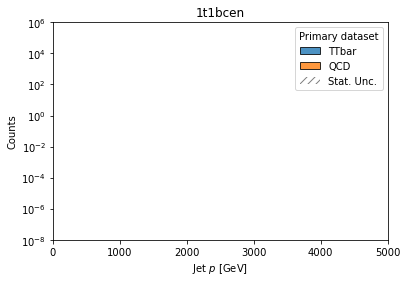

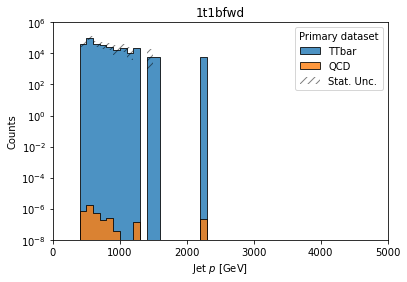

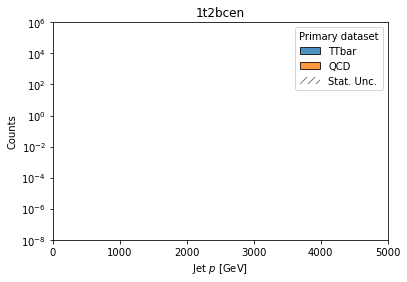

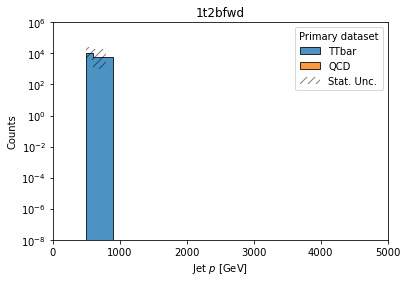

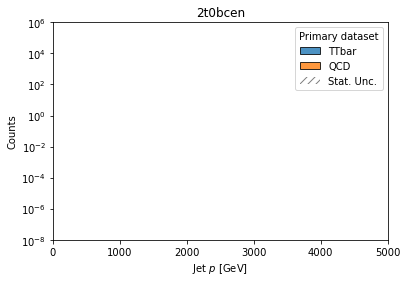

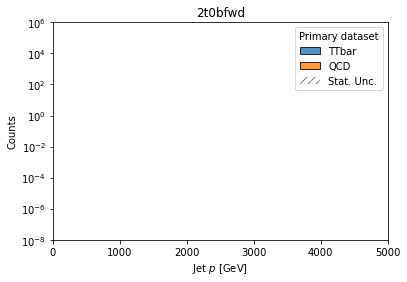

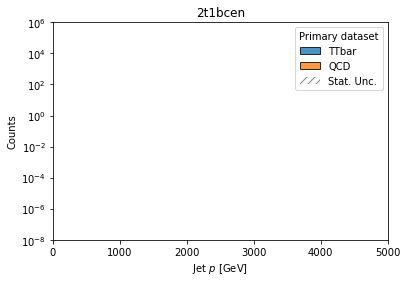

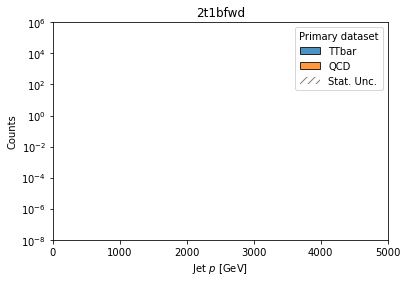

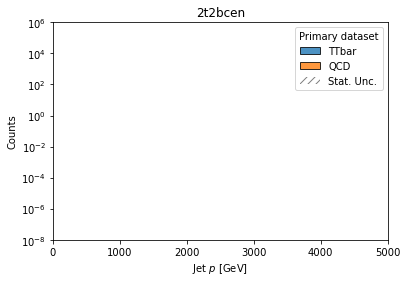

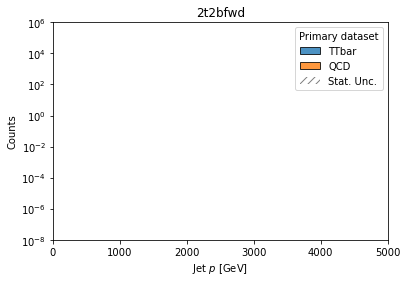

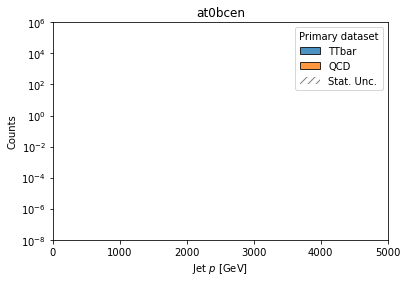

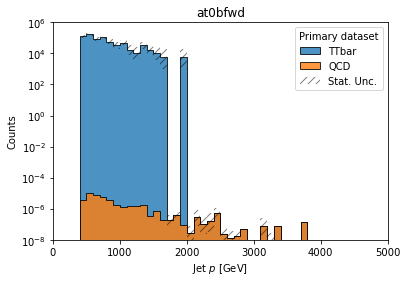

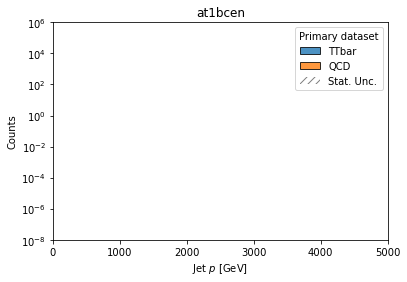

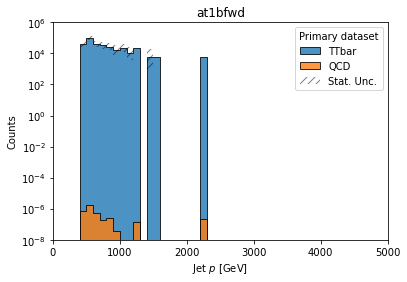

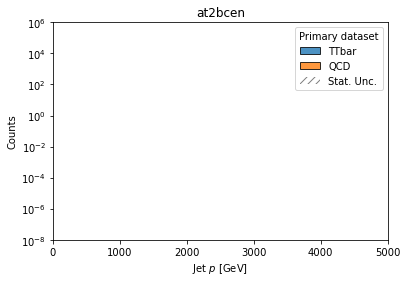

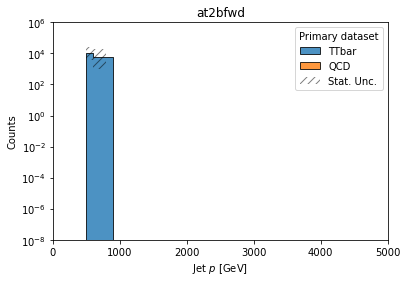

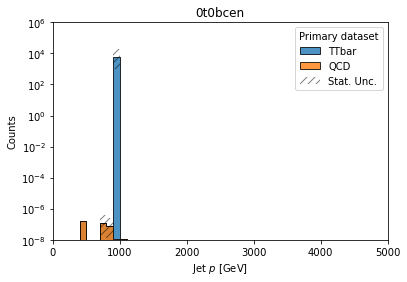

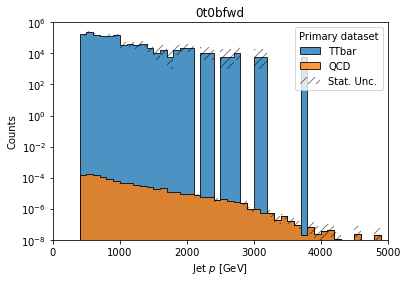

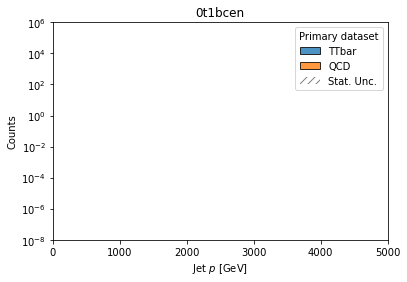

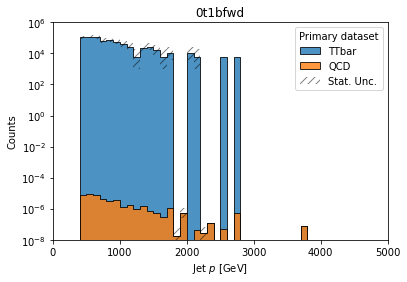

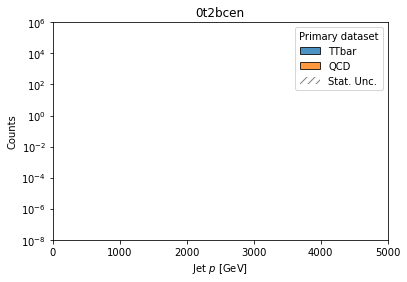

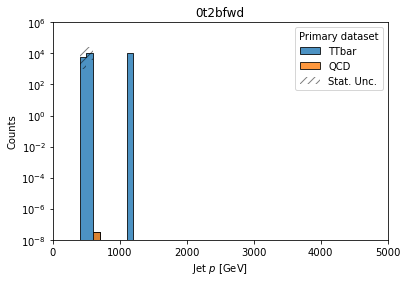

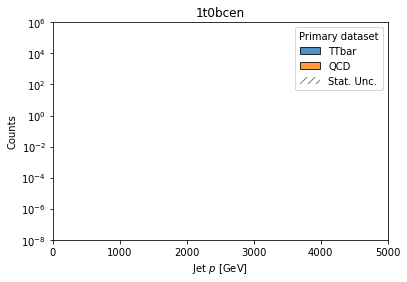

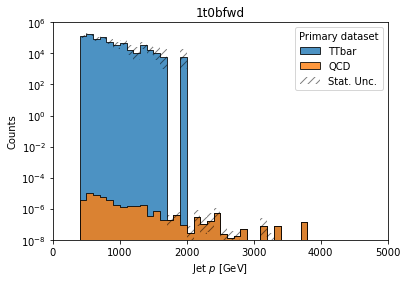

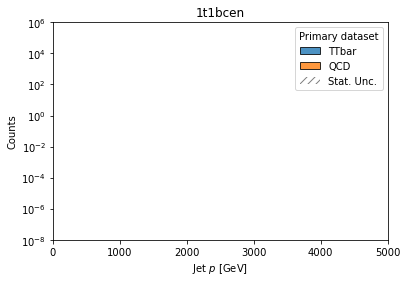

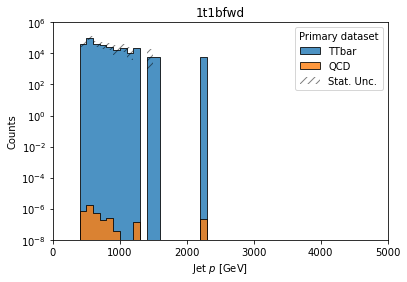

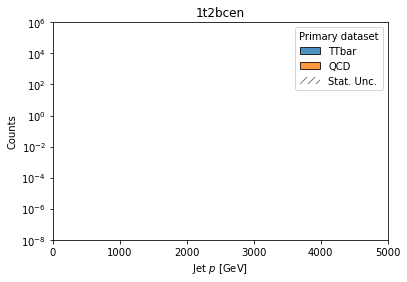

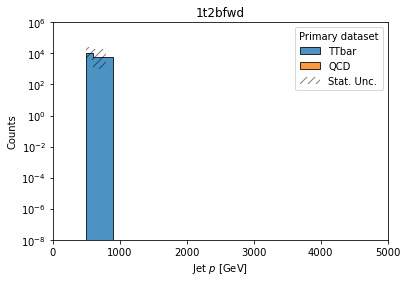

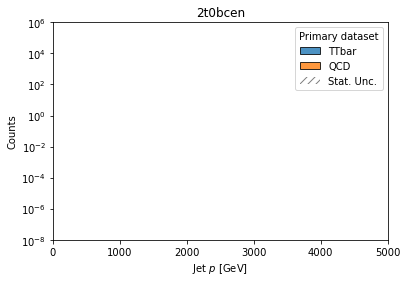

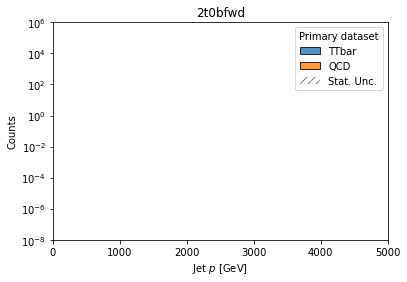

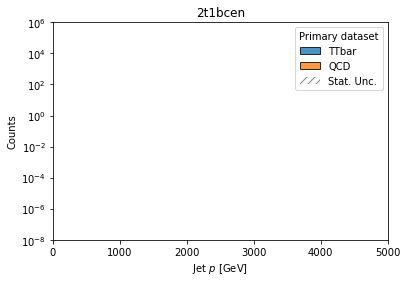

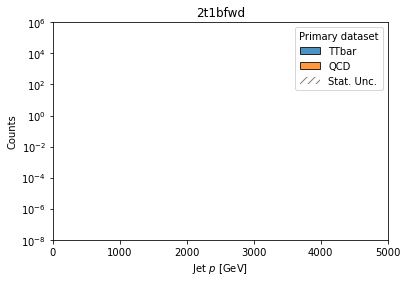

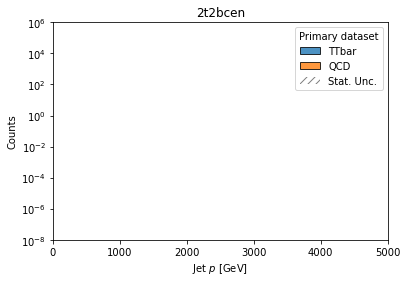

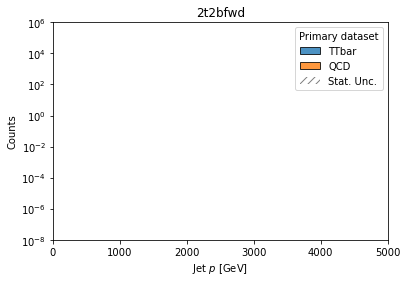

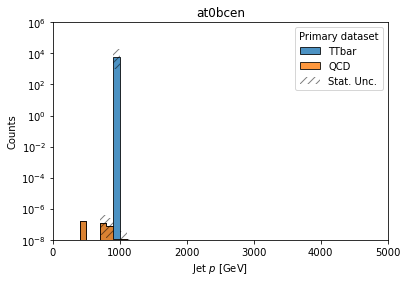

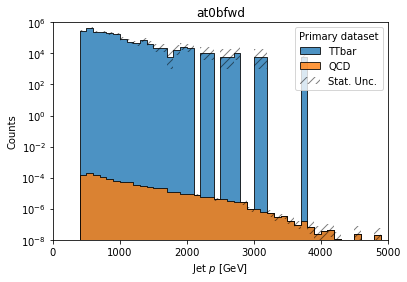

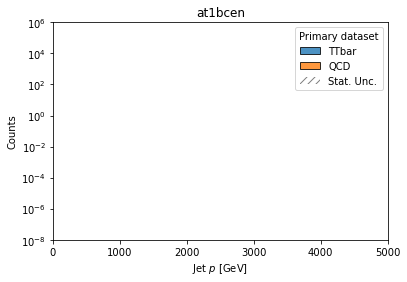

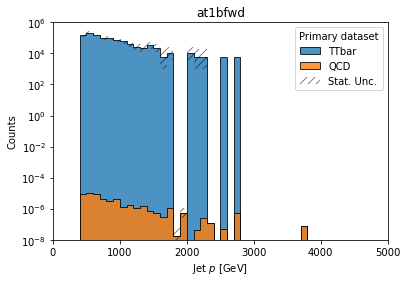

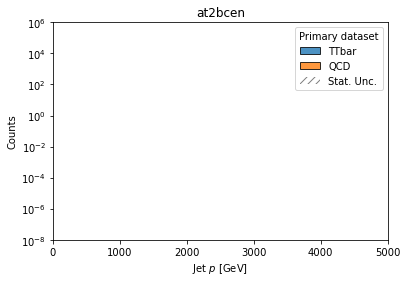

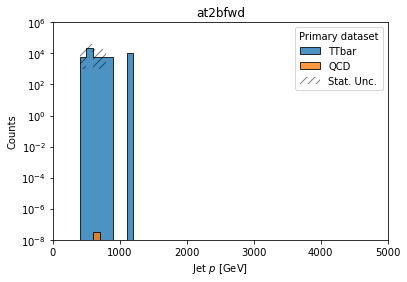

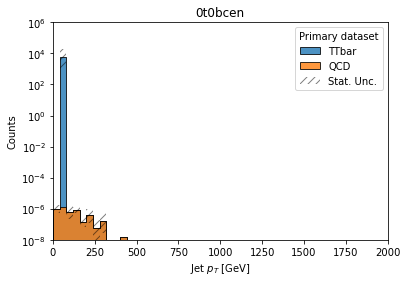

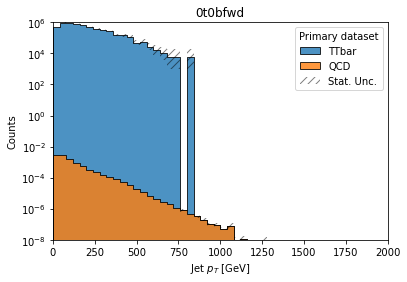

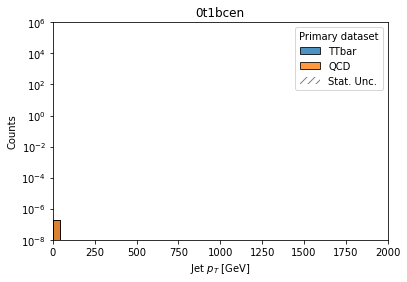

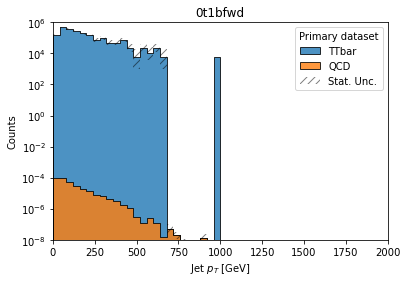

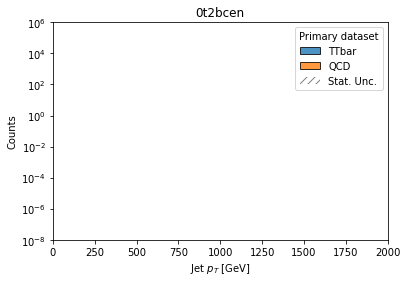

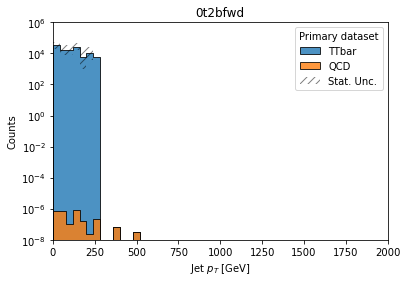

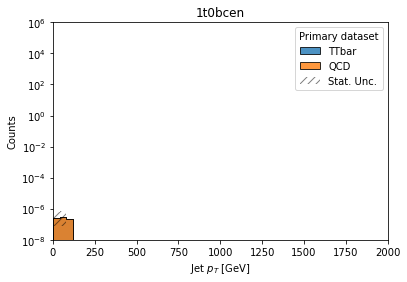

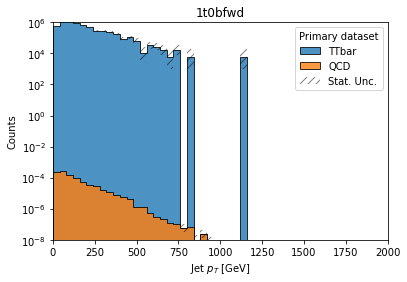

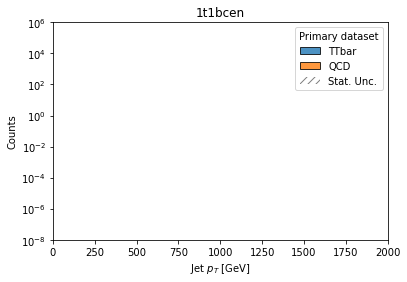

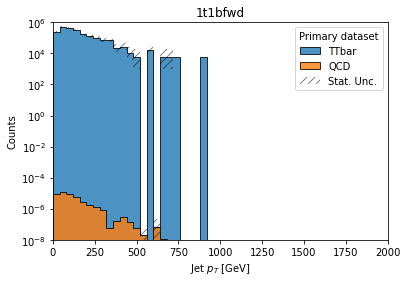

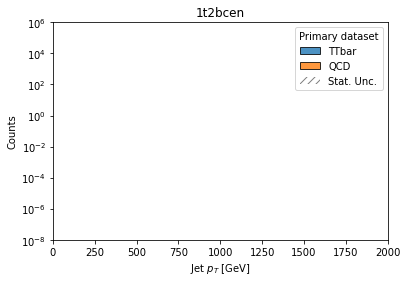

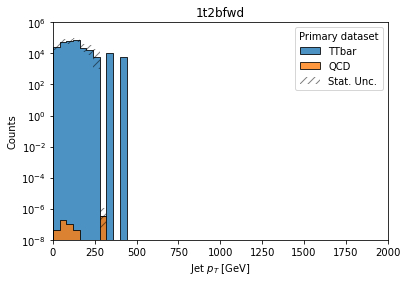

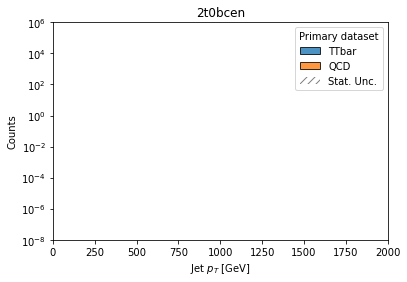

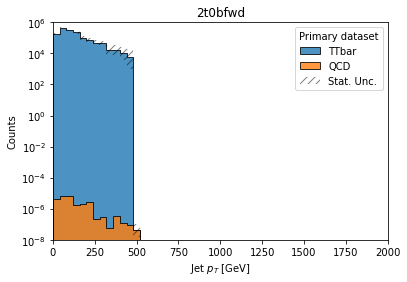

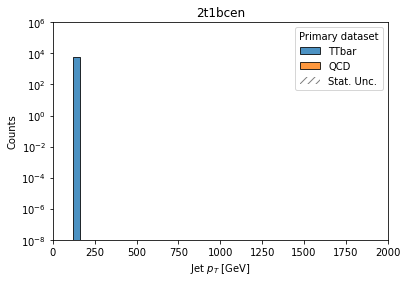

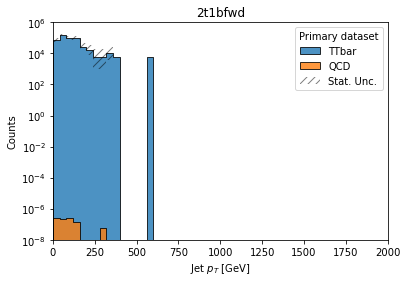

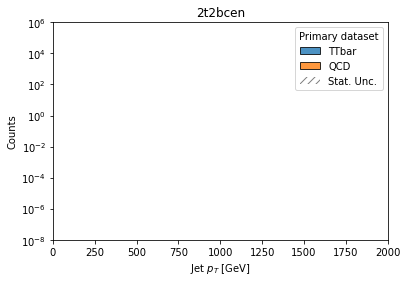

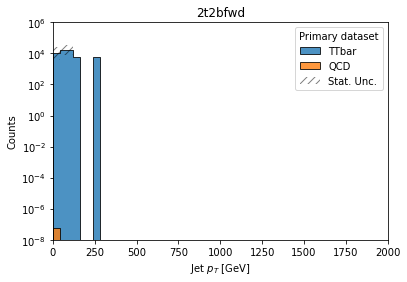

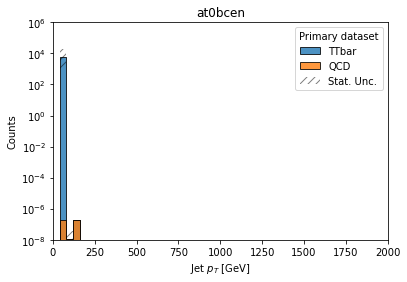

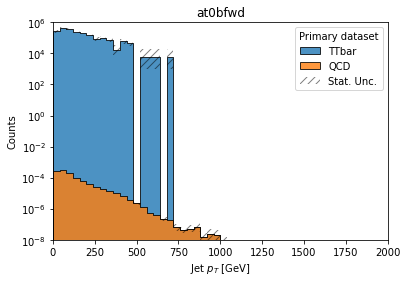

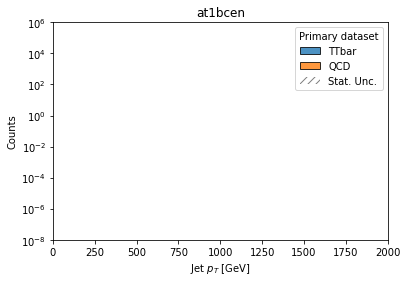

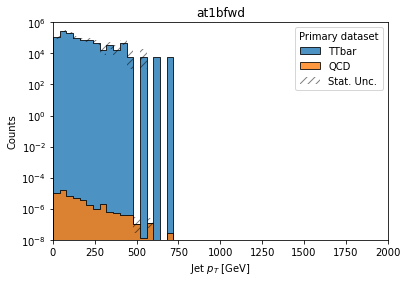

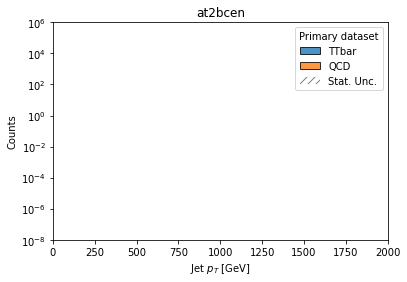

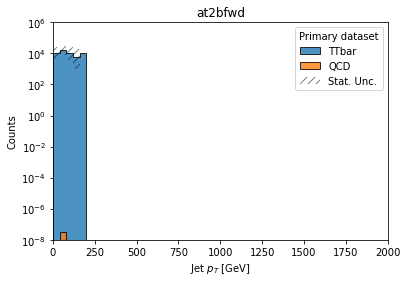

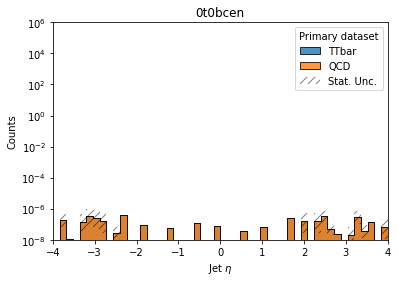

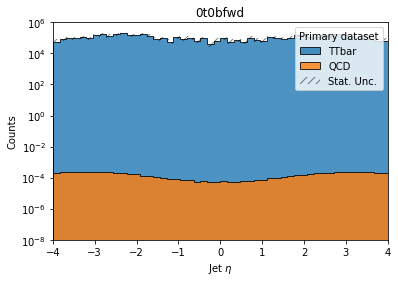

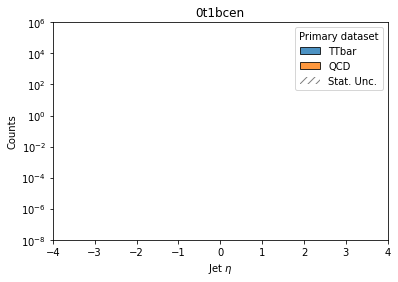

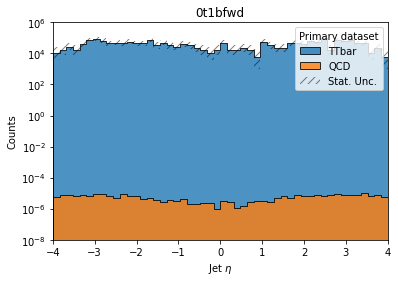

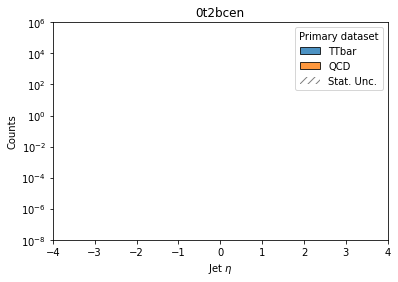

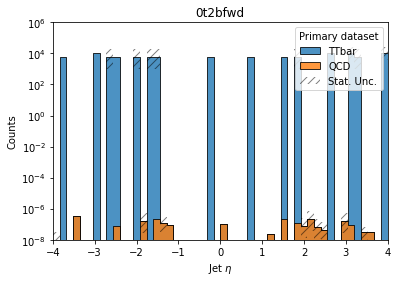

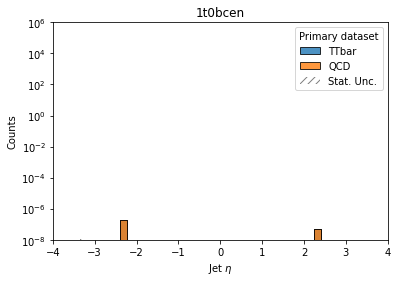

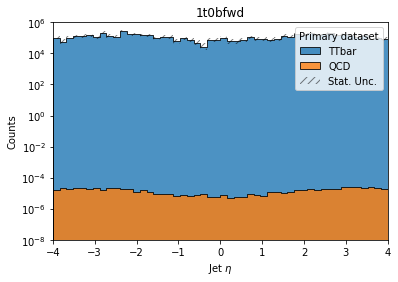

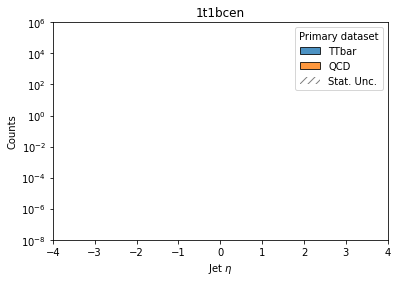

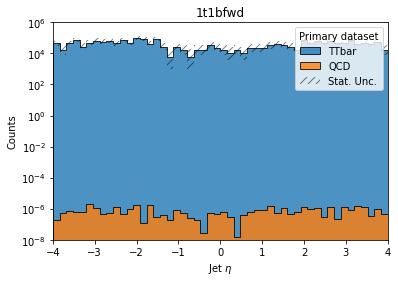

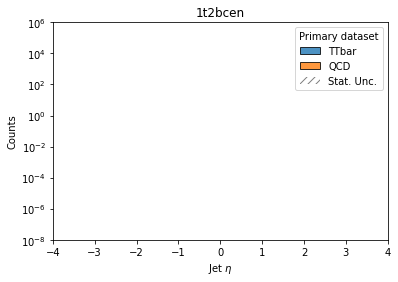

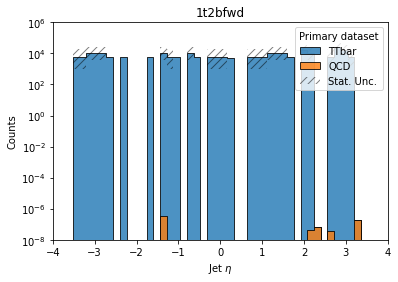

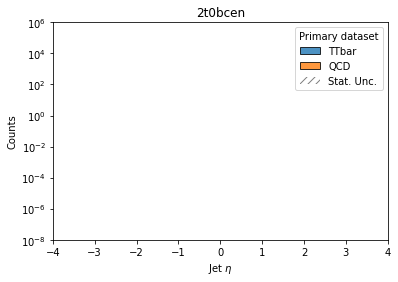

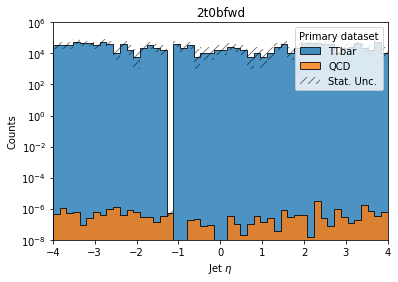

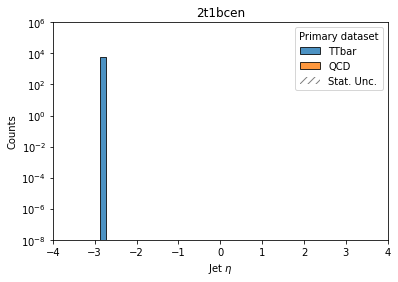

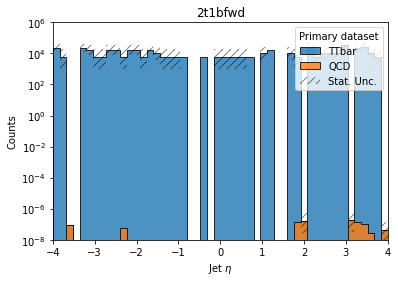

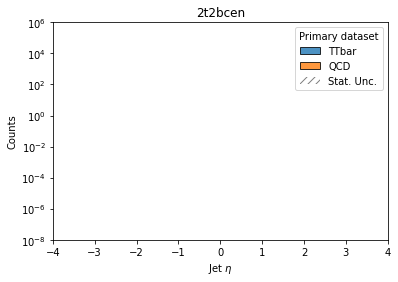

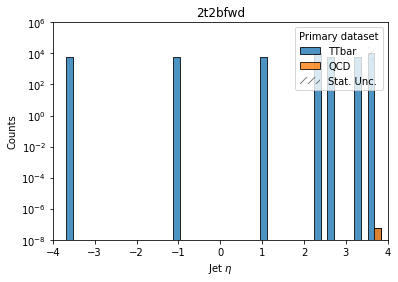

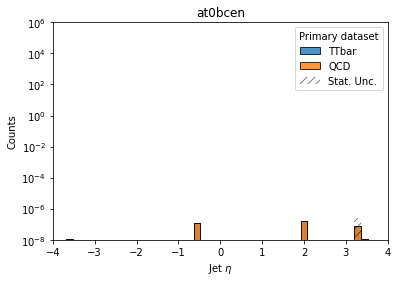

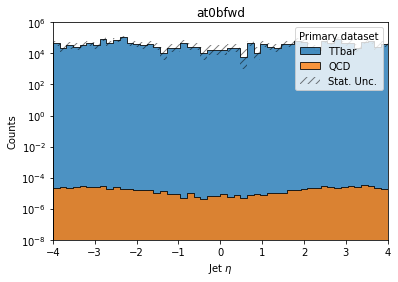

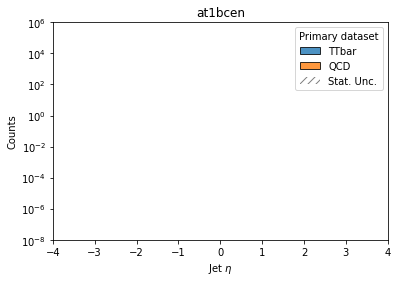

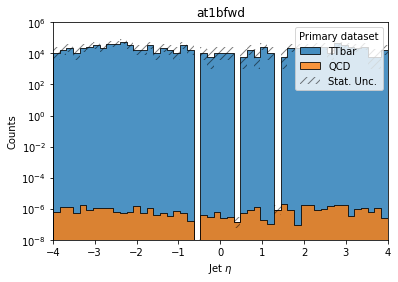

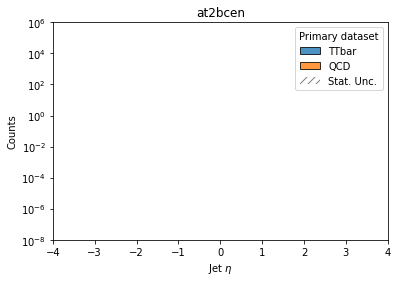

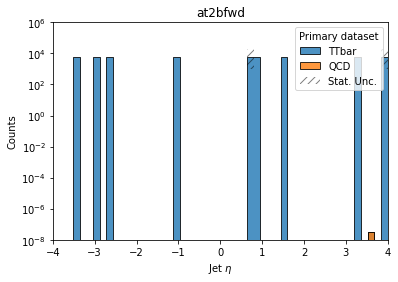

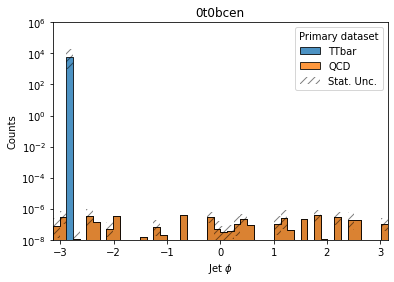

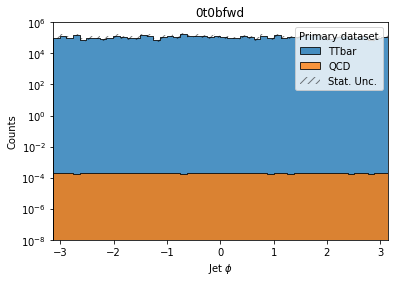

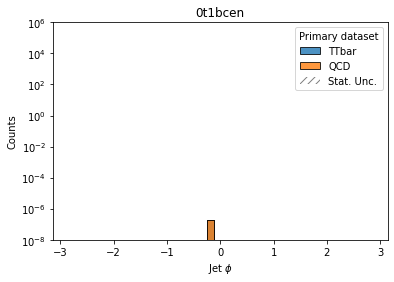

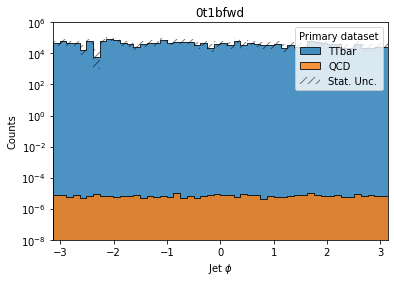

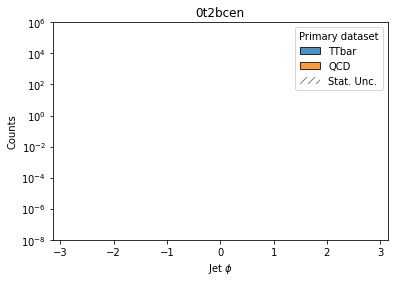

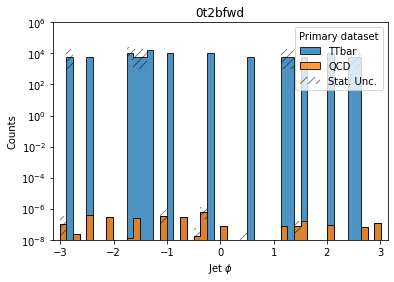

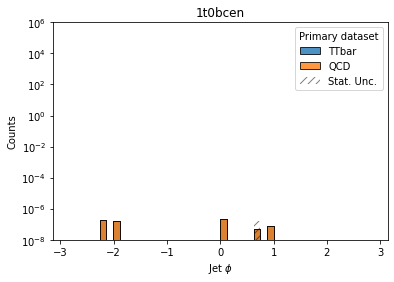

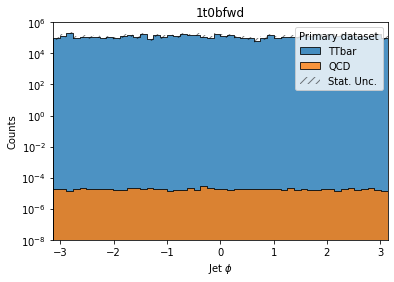

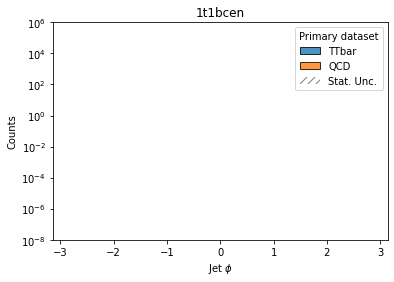

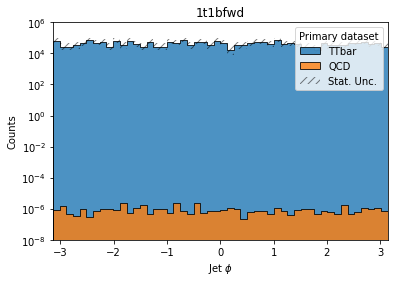

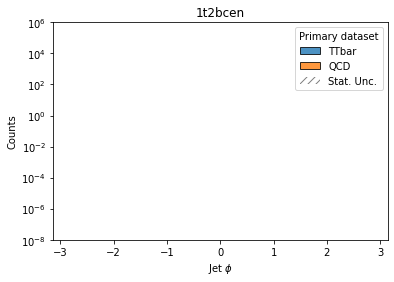

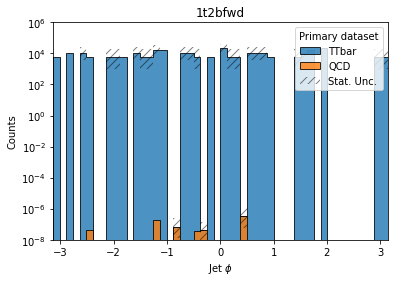

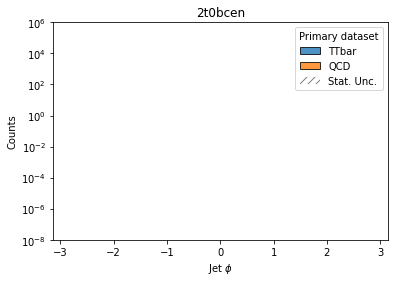

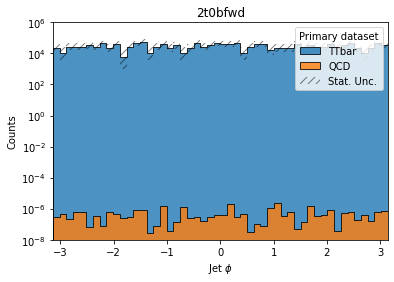

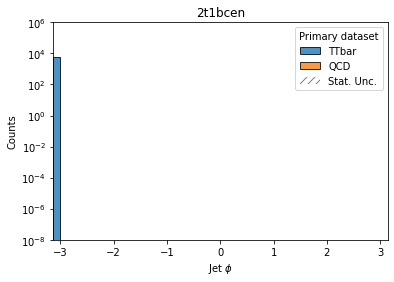

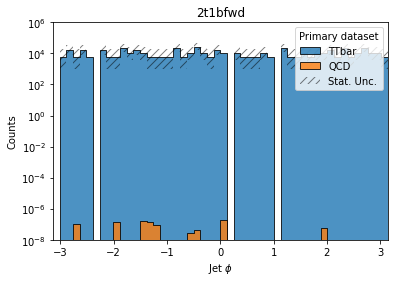

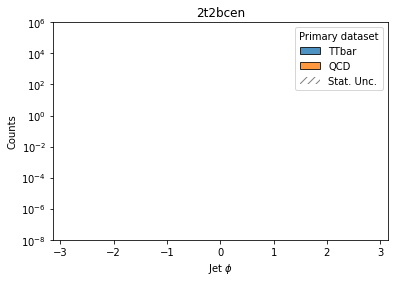

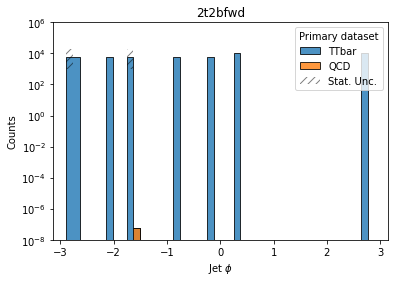

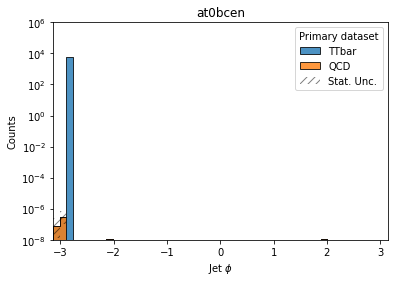

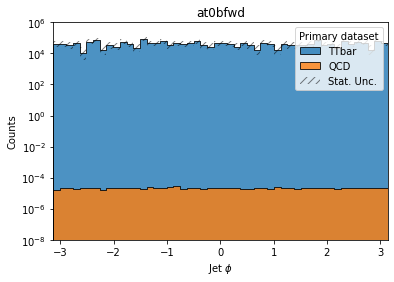

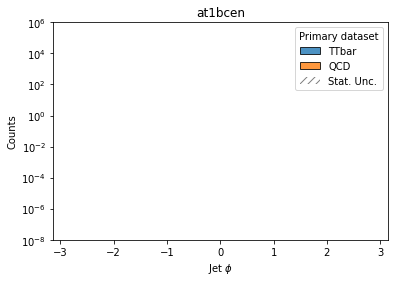

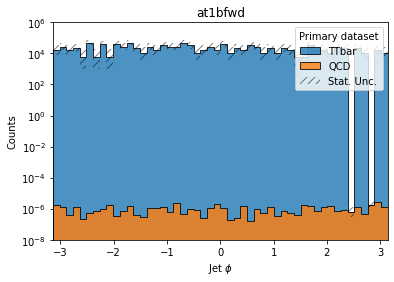

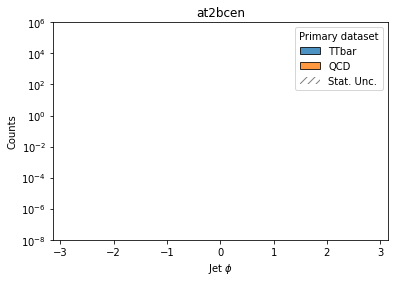

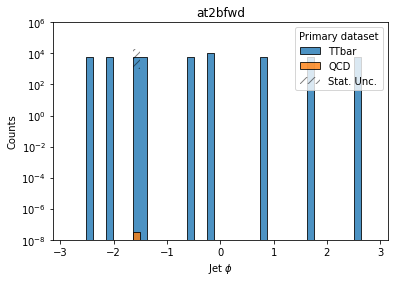

In [30]:
directory = '/uscms_data/d1/acwillia/singularity/TTbarAllHadUprootFork/TTbarAllHadUproot' # change accordingly...

SaveDirectory = directory + '/MistagPlots'
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times

for iax in axes_numerator.flatten():
    category = iax.get_title()
    Numerator = output['numerator'].integrate('anacat', category).integrate('dataset', 'TTbar')
    Denominator = output['denominator'].integrate('anacat', category).integrate('dataset', 'TTbar')
    mistag = hist.plotratio(num = Numerator, denom = Denominator,
                            error_opts={'color': 'b', 'marker': 'x', 'ms':5},
                            unc = 'clopper-pearson')
    SavePlot(mistag, category, 'mistag_TTbar', 'pdf', SaveDirectory)
    


for iax in axes_numerator.flatten():
    category = iax.get_title()
    Numerator = output['numerator'].integrate('anacat', category).integrate('dataset', 'QCD')
    Denominator = output['denominator'].integrate('anacat', category).integrate('dataset', 'QCD')
    mistag = hist.plotratio(num = Numerator, denom = Denominator,
                            error_opts={'color': 'r', 'marker': '+', 'ms':5},
                            unc = 'clopper-pearson')
    SavePlot(mistag, category, 'mistag_QCD', 'pdf', SaveDirectory)
    

"""
for iax in axes_numerator.flatten():
    category = iax.get_title()
    Numerator = output['numerator'].integrate('anacat', category).integrate('dataset', 'JetHT')
    Denominator = output['denominator'].integrate('anacat', category).integrate('dataset', 'JetHT')
    mistag = hist.plotratio(num = Numerator, denom = Denominator,
                            error_opts={'color': 'g', 'marker': '*', 'ms':5},
                            unc = 'clopper-pearson')
    SavePlot(mistag, category, 'mistag_JetHT', 'pdf', SaveDirectory)
"""    
"""___________________________________________________________________________________________________________"""

SaveDirectory = directory + '/TTbarmassPlots'
DoesDirectoryExist(SaveDirectory) 
for iax in axes_ttbarmass.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['ttbarmass'].integrate('anacat',category), overlay="dataset", stack=True, 
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'ttbarmass', 'pdf', SaveDirectory)


SaveDirectory = directory + '/NumeratorPlots'
DoesDirectoryExist(SaveDirectory) 
for iax in axes_numerator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['numerator'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'numerator', 'pdf', SaveDirectory)

    

SaveDirectory = directory + '/DenominatorPlots'
DoesDirectoryExist(SaveDirectory)
for iax in axes_denominator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['denominator'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'denominator', 'pdf', SaveDirectory)



SaveDirectory = directory + '/JetptPlots'
DoesDirectoryExist(SaveDirectory)
for iax in axes_denominator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['jetpt'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'jetpt', 'pdf', SaveDirectory)


SaveDirectory = directory + '/JetetaPlots'
DoesDirectoryExist(SaveDirectory)
for iax in axes_denominator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['jeteta'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'jeteta', 'pdf', SaveDirectory)


SaveDirectory = directory + '/JetphiPlots'
DoesDirectoryExist(SaveDirectory)
for iax in axes_denominator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['jetphi'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'jetphi', 'pdf', SaveDirectory)

In [40]:
import pandas as pd

for iset in fileset:
    print('\t\tfileset: ' + iset + '\n*****************************************************\n')
    for iax in axes_numerator.flatten():
        category = iax.get_title()
        Numerator = output['numerator'].integrate('anacat',category).integrate('dataset',iset)
        Denominator = output['denominator'].integrate('anacat',category).integrate('dataset',iset)
        
        N_vals = Numerator.values()[()]
        D_vals = Denominator.values()[()]
    
        mistag_vals = np.where(D_vals > 0, N_vals / D_vals, 0)
        
        p_vals = [] # Momentum values
        for iden in Numerator.identifiers('jetp'):
            p_vals.append(iden)
        
        print('category: ' + category + '_________________________________________')

        d = {'p': p_vals, 'M(p)': mistag_vals}
        
        df = pd.DataFrame(data=d)
        
        with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
            print(df)
        print('\n')

		fileset: TTbar
*****************************************************

category: 0t0bcen_________________________________________
               p  M(p)
0       [0, 100)   0.0
1     [100, 200)   0.0
2     [200, 300)   0.0
3     [300, 400)   0.0
4     [400, 500)   0.0
5     [500, 600)   0.0
6     [600, 700)   0.0
7     [700, 800)   0.0
8     [800, 900)   0.0
9    [900, 1000)   0.0
10  [1000, 1100)   0.0
11  [1100, 1200)   0.0
12  [1200, 1300)   0.0
13  [1300, 1400)   0.0
14  [1400, 1500)   0.0
15  [1500, 1600)   0.0
16  [1600, 1700)   0.0
17  [1700, 1800)   0.0
18  [1800, 1900)   0.0
19  [1900, 2000)   0.0
20  [2000, 2100)   0.0
21  [2100, 2200)   0.0
22  [2200, 2300)   0.0
23  [2300, 2400)   0.0
24  [2400, 2500)   0.0
25  [2500, 2600)   0.0
26  [2600, 2700)   0.0
27  [2700, 2800)   0.0
28  [2800, 2900)   0.0
29  [2900, 3000)   0.0
30  [3000, 3100)   0.0
31  [3100, 3200)   0.0
32  [3200, 3300)   0.0
33  [3300, 3400)   0.0
34  [3400, 3500)   0.0
35  [3500, 3600)   0.0
36  [3600, 3700)  

In [41]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 6977.071777318659


In [42]:
for i,j in output['cutflow'].items():
    print( '%20s : %12d' % (i,j) )

          all events :      2973429
         one FatJets :      1229403
         two FatJets :       856999
              jet id :       856930
             jet kin :       396414
two FatJets and jet kin :       295923
     >= one oneTTbar :       295923
          dPhi > 2.1 :       147570
             at0bcen :            8
             at0bfwd :        13061
             at1bcen :            1
             at1bfwd :          684
             at2bcen :            0
             at2bfwd :           19
             0t0bcen :           54
             0t0bfwd :       129168
             0t1bcen :            2
             0t1bfwd :         3744
             0t2bcen :            0
             0t2bfwd :           58
             1t0bcen :            9
             1t0bfwd :        12636
             1t1bcen :            0
             1t1bfwd :         1002
             1t2bcen :            0
             1t2bfwd :           74
             2t0bcen :            0
             2t0bfwd :   

In [ ]:

#mapping = {
#    'QCD': ['QCD'],
#}
#output['ttbarmass'].group("dataset", hist.Cat("dataset", "dataset"), mapping)
#hist_noDS = output['ttbarmass_pretag'].integrate('dataset')
